In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import math
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, Flatten, TimeDistributed, MaxPooling1D, Activation, Reshape, BatchNormalization

#Load and Prepare Data

In [ ]:
# load the raw data for each subset
def load_dataframe(subset_number):
    directory = 'C-MAPSS/'
    if not os.path.exists(directory):
        os.makedirs(directory)

#load the train file for each of the 4 subsets
    train_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/train_FD00{subset_number}.txt"
    os.system(f"wget -q {train_url} -O {directory}train_FD00{subset_number}.txt")
    turbo_train = pd.read_csv(f"{directory}train_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

#load the test file for each of the 4 subsets
    test_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/test_FD00{subset_number}.txt"
    os.system(f"wget -q {test_url} -O {directory}test_FD00{subset_number}.txt")
    turbo_test = pd.read_csv(f"{directory}test_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

#load the target (RUL) file for each of the 4 subsets
    rul_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/RUL_FD00{subset_number}.txt"
    os.system(f"wget -q {rul_url} -O {directory}RUL_FD00{subset_number}.txt")
    y_RUL = pd.read_csv(f"{directory}RUL_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    return turbo_train, turbo_test, y_RUL

In [ ]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [ ]:
turbo_train_1

0    1       2       3      4       5       6        7        8   \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
20626  100  196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
20627  100  197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
20628  100  198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
20629  100  199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
20630  100  200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   

          9   ...      16       17       18      19    20   21    22     23  \
0      14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1      14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2      14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3      14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4      14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
...      ...  ...     ...      ...      ...     ...   ...  ...   ...    ...   
20626  14.62  ...  519.49  2388.26  8137.60  8.4956  0.03  397  2388  100.0   
20627  14.62  ...  519.68  2388.22  8136.50  8.5139  0.03  395  2388  100.0   
20628  14.62  ...  520.01  2388.24  8141.05  8.5646  0.03  398  2388  100.0   
20629  14.62  ...  519.67  2388.23  8139.29  8.5389  0.03  395  2388  100.0   
20630  14.62  ...  519.30  2388.26  8137.33  8.5036  0.03  396  2388  100.0   

          24       25  
0      39.06  23.4190  
1      39.00  23.4236  
2      38.95  23.3442  
3      38.88  23.3739  
4      38.90  23.4044  
...      ...      ...  
20626  38.49  22.9735  
20627  38.30  23.1594  
20628  38.44  22.9333  
20629  38.29  23.0640  
20630  38.37  23.0522  

[20631 rows x 26 columns]

In [ ]:
#count the number of unique engines for each subset (useful for subsequent functions)
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [ ]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [ ]:
nr_train_1

100

In [ ]:
# assign the original RUL to the training set (assuming that RUL decreases linearly from the start)
def original_RUL_train(turbo_train):
  turbo_train.sort_values(by=[0, 1], inplace=True)
  turbo_train['RUL'] = turbo_train.groupby(0).cumcount(ascending=False)
  return turbo_train

In [ ]:
turbo_train_1=original_RUL_train(turbo_train_1)
turbo_train_2=original_RUL_train(turbo_train_2)
turbo_train_3=original_RUL_train(turbo_train_3)
turbo_train_4=original_RUL_train(turbo_train_4)

In [ ]:
turbo_train_1

0    1       2       3      4       5       6        7        8  \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
20626  100  196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
20627  100  197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
20628  100  198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
20629  100  199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
20630  100  200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   

           9  ...       17       18      19    20   21    22     23     24  \
0      14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1      14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2      14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3      14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4      14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   
...      ...  ...      ...      ...     ...   ...  ...   ...    ...    ...   
20626  14.62  ...  2388.26  8137.60  8.4956  0.03  397  2388  100.0  38.49   
20627  14.62  ...  2388.22  8136.50  8.5139  0.03  395  2388  100.0  38.30   
20628  14.62  ...  2388.24  8141.05  8.5646  0.03  398  2388  100.0  38.44   
20629  14.62  ...  2388.23  8139.29  8.5389  0.03  395  2388  100.0  38.29   
20630  14.62  ...  2388.26  8137.33  8.5036  0.03  396  2388  100.0  38.37   

            25  RUL  
0      23.4190  191  
1      23.4236  190  
2      23.3442  189  
3      23.3739  188  
4      23.4044  187  
...        ...  ...  
20626  22.9735    4  
20627  23.1594    3  
20628  22.9333    2  
20629  23.0640    1  
20630  23.0522    0  

[20631 rows x 27 columns]

In [ ]:
 # assign the original RUL to the testing set (assuming that RUL decreases linearly from the start)
def original_RUL_test(turbo_test, y_RUL):
  y_RUL_series=y_RUL[0]
  turbo_test.sort_values(by=[0, 1], inplace=True)
  adjusted_engine_numbers = turbo_test[0].values - 1
  turbo_test['RUL'] = turbo_test.groupby(0).cumcount(ascending=False) + y_RUL_series.iloc[adjusted_engine_numbers].values
  return turbo_test

In [ ]:
turbo_test_1=original_RUL_test(turbo_test_1, y_RUL_1)
turbo_test_2=original_RUL_test(turbo_test_2, y_RUL_2)
turbo_test_3=original_RUL_test(turbo_test_3, y_RUL_3)
turbo_test_4=original_RUL_test(turbo_test_4, y_RUL_4)

In [ ]:
turbo_test_1

0    1       2       3      4       5       6        7        8  \
0        1    1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21   
1        1    2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42   
2        1    3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34   
3        1    4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42   
4        1    5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
13091  100  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
13092  100  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
13093  100  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
13094  100  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
13095  100  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

           9  ...       17       18      19    20   21    22     23     24  \
0      14.62  ...  2388.03  8125.55  8.4052  0.03  392  2388  100.0  38.86   
1      14.62  ...  2388.06  8139.62  8.3803  0.03  393  2388  100.0  39.02   
2      14.62  ...  2388.03  8130.10  8.4441  0.03  393  2388  100.0  39.08   
3      14.62  ...  2388.05  8132.90  8.3917  0.03  391  2388  100.0  39.00   
4      14.62  ...  2388.03  8129.54  8.4031  0.03  390  2388  100.0  38.99   
...      ...  ...      ...      ...     ...   ...  ...   ...    ...    ...   
13091  14.62  ...  2388.00  8213.28  8.4715  0.03  394  2388  100.0  38.65   
13092  14.62  ...  2388.09  8210.85  8.4512  0.03  395  2388  100.0  38.57   
13093  14.62  ...  2388.04  8217.24  8.4569  0.03  395  2388  100.0  38.62   
13094  14.62  ...  2388.08  8220.48  8.4711  0.03  395  2388  100.0  38.66   
13095  14.62  ...  2388.05  8214.64  8.4903  0.03  396  2388  100.0  38.70   

            25  RUL  
0      23.3735  142  
1      23.3916  141  
2      23.4166  140  
3      23.3737  139  
4      23.4130  138  
...        ...  ...  
13091  23.1974   24  
13092  23.2771   23  
13093  23.2051   22  
13094  23.2699   21  
13095  23.1855   20  

[13096 rows x 27 columns]

In [ ]:
#concatenate training and testing set for subsequent operations
#reset engines indexes for the training set, so the count starts where the training engines left off (ex. for FD001, engine 1 becomes engine 101)
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [ ]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [ ]:
turbofan1

0    1       2       3      4       5       6        7        8  \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
33722  200  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
33723  200  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
33724  200  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
33725  200  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
33726  200  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

           9  ...       17       18      19    20   21    22     23     24  \
0      14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1      14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2      14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3      14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4      14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   
...      ...  ...      ...      ...     ...   ...  ...   ...    ...    ...   
33722  14.62  ...  2388.00  8213.28  8.4715  0.03  394  2388  100.0  38.65   
33723  14.62  ...  2388.09  8210.85  8.4512  0.03  395  2388  100.0  38.57   
33724  14.62  ...  2388.04  8217.24  8.4569  0.03  395  2388  100.0  38.62   
33725  14.62  ...  2388.08  8220.48  8.4711  0.03  395  2388  100.0  38.66   
33726  14.62  ...  2388.05  8214.64  8.4903  0.03  396  2388  100.0  38.70   

            25  RUL  
0      23.4190  191  
1      23.4236  190  
2      23.3442  189  
3      23.3739  188  
4      23.4044  187  
...        ...  ...  
33722  23.1974   24  
33723  23.2771   23  
33724  23.2051   22  
33725  23.2699   21  
33726  23.1855   20  

[33727 rows x 27 columns]

In [ ]:
# rename columns as in the original paper (Saxena and Goebel, 2008)
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
                 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf-dmd', 'PCNfR-dmd', 'W31', 'W32', 'RUL']
  turbofan.columns = new_columns
  return turbofan

In [ ]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [ ]:
turbofan1

ENr    C    OP-1    OP-2   OP-3      T2     T24      T30      T50  \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
33722  200  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
33723  200  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
33724  200  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
33725  200  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
33726  200  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

          P2  ...      NRf      NRc     BPR  farB  htBleed  Nf-dmd  PCNfR-dmd  \
0      14.62  ...  2388.02  8138.62  8.4195  0.03      392    2388      100.0   
1      14.62  ...  2388.07  8131.49  8.4318  0.03      392    2388      100.0   
2      14.62  ...  2388.03  8133.23  8.4178  0.03      390    2388      100.0   
3      14.62  ...  2388.08  8133.83  8.3682  0.03      392    2388      100.0   
4      14.62  ...  2388.04  8133.80  8.4294  0.03      393    2388      100.0   
...      ...  ...      ...      ...     ...   ...      ...     ...        ...   
33722  14.62  ...  2388.00  8213.28  8.4715  0.03      394    2388      100.0   
33723  14.62  ...  2388.09  8210.85  8.4512  0.03      395    2388      100.0   
33724  14.62  ...  2388.04  8217.24  8.4569  0.03      395    2388      100.0   
33725  14.62  ...  2388.08  8220.48  8.4711  0.03      395    2388      100.0   
33726  14.62  ...  2388.05  8214.64  8.4903  0.03      396    2388      100.0   

         W31      W32  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
33722  38.65  23.1974   24  
33723  38.57  23.2771   23  
33724  38.62  23.2051   22  
33725  38.66  23.2699   21  
33726  38.70  23.1855   20  

[33727 rows x 27 columns]

#Exploratory Data Analysis (EDA)

##Univariate

In [ ]:
# check data type and null values
def get_info(turbofan):
   return turbofan.info()

In [ ]:
info1=get_info(turbofan1)
info2=get_info(turbofan2)
info3=get_info(turbofan3)
info4=get_info(turbofan4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33727 entries, 0 to 33726
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ENr        33727 non-null  int64  
 1   C          33727 non-null  int64  
 2   OP-1       33727 non-null  float64
 3   OP-2       33727 non-null  float64
 4   OP-3       33727 non-null  float64
 5   T2         33727 non-null  float64
 6   T24        33727 non-null  float64
 7   T30        33727 non-null  float64
 8   T50        33727 non-null  float64
 9   P2         33727 non-null  float64
 10  P15        33727 non-null  float64
 11  P30        33727 non-null  float64
 12  Nf         33727 non-null  float64
 13  Nc         33727 non-null  float64
 14  epr        33727 non-null  float64
 15  Ps30       33727 non-null  float64
 16  phi        33727 non-null  float64
 17  NRf        33727 non-null  float64
 18  NRc        33727 non-null  float64
 19  BPR        33727 non-null  float64
 20  farB  

In [ ]:
#check missing values
def check_missing(turbofan):
   return turbofan.isnull().sum()

In [ ]:
missing1=check_missing(turbofan1)
missing2=check_missing(turbofan2)
missing3=check_missing(turbofan3)
missing4=check_missing(turbofan4)

In [ ]:
missing1

ENr          0
C            0
OP-1         0
OP-2         0
OP-3         0
T2           0
T24          0
T30          0
T50          0
P2           0
P15          0
P30          0
Nf           0
Nc           0
epr          0
Ps30         0
phi          0
NRf          0
NRc          0
BPR          0
farB         0
htBleed      0
Nf-dmd       0
PCNfR-dmd    0
W31          0
W32          0
RUL          0
dtype: int64

In [ ]:
#check number of unique values
def unique_values(turbofan):
   return turbofan.nunique()

In [ ]:
unique1=unique_values(turbofan1)
unique2=unique_values(turbofan2)
unique3=unique_values(turbofan3)
unique4=unique_values(turbofan4)

In [ ]:
unique1

ENr           200
C             362
OP-1          164
OP-2           14
OP-3            1
T2              1
T24           315
T30          3156
T50          4206
P2              1
P15             2
P30           523
Nf             54
Nc           6882
epr             1
Ps30          162
phi           436
NRf            56
NRc          6457
BPR          1975
farB            1
htBleed        13
Nf-dmd          1
PCNfR-dmd       1
W31           123
W32          5014
RUL           362
dtype: int64

NOTE: Here we can see the columns with constant columns and the attributes dependent on the number of conditions

In [ ]:
# compute mean, standard deviation, min, max, quantiles, skewness and kurtosis
def statistics(turbofan):
  description=turbofan.describe()
  skewness = turbofan.apply(skew)
  kurt = turbofan.apply(kurtosis)
  statistics = turbofan.describe()
  statistics.loc['skewness'] = skewness
  statistics.loc['kurtosis'] = kurt
  return statistics

In [ ]:
stat1=statistics(turbofan1)
stat2=statistics(turbofan2)
stat3=statistics(turbofan3)
stat4=statistics(turbofan4)

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.f(v)


NOTE: The warning is generated when calculating skewness and kurtosis for the constant attributes (because division is made with 0)

In [ ]:
stat1

ENr             C          OP-1          OP-2     OP-3  \
count     33727.000000  33727.000000  33727.000000  33727.000000  33727.0   
mean         90.350491     96.393572     -0.000010      0.000003    100.0   
std          56.659857     65.100528      0.002193      0.000293      0.0   
min           1.000000      1.000000     -0.008700     -0.000600    100.0   
25%          43.000000     43.000000     -0.001500     -0.000200    100.0   
50%          83.000000     88.000000      0.000000      0.000000    100.0   
75%         137.000000    140.000000      0.001500      0.000300    100.0   
max         200.000000    362.000000      0.008700      0.000700    100.0   
skewness      0.265306      0.667458     -0.015933      0.011955      NaN   
kurtosis     -1.062898      0.067624     -0.002288     -1.130819      NaN   

                T2           T24           T30           T50            P2  \
count     33727.00  33727.000000  33727.000000  33727.000000  3.372700e+04   
mean        518.67    642.601005   1589.581927   1407.303559  1.462000e+01   
std           0.00      0.474789      5.840324      8.432656  3.552766e-15   
min         518.67    641.130000   1569.040000   1382.250000  1.462000e+01   
25%         518.67    642.270000   1585.530000   1401.230000  1.462000e+01   
50%         518.67    642.560000   1589.210000   1406.450000  1.462000e+01   
75%         518.67    642.890000   1593.160000   1412.240000  1.462000e+01   
max         518.67    644.530000   1616.910000   1441.490000  1.462000e+01   
skewness       NaN      0.396865      0.362297      0.570333           NaN   
kurtosis       NaN      0.112000      0.193295      0.206702           NaN   

          ...           NRf           NRc           BPR          farB  \
count     ...  33727.000000  33727.000000  33727.000000  3.372700e+04   
mean      ...   2388.086395   8141.887005      8.435816  3.000000e-02   
std       ...      0.067620     16.382482      0.035360  1.387799e-17   
min       ...   2387.880000   8099.940000      8.324900  3.000000e-02   
25%       ...   2388.040000   8132.780000      8.411000  3.000000e-02   
50%       ...   2388.080000   8139.620000      8.432400  3.000000e-02   
75%       ...   2388.130000   8146.600000      8.457000  3.000000e-02   
max       ...   2388.560000   8293.720000      8.584800  3.000000e-02   
skewness  ...      0.522127      2.619111      0.483587           NaN   
kurtosis  ...      0.542045     11.915216      0.174608           NaN   

               htBleed   Nf-dmd  PCNfR-dmd           W31           W32  \
count     33727.000000  33727.0    33727.0  33727.000000  33727.000000   
mean        392.962523   2388.0      100.0     38.845871     23.307581   
std           1.468023      0.0        0.0      0.170757      0.102073   
min         388.000000   2388.0      100.0     38.140000     22.894200   
25%         392.000000   2388.0      100.0     38.740000     23.245900   
50%         393.000000   2388.0      100.0     38.860000     23.316600   
75%         394.000000   2388.0      100.0     38.970000     23.379200   
max         400.000000   2388.0      100.0     39.430000     23.641900   
skewness      0.425383      NaN        NaN     -0.444441     -0.447665   
kurtosis      0.199001      NaN        NaN      0.174333      0.164797   

                   RUL  
count     33727.000000  
mean        120.788775  
std          67.218901  
min           0.000000  
25%          68.000000  
50%         121.000000  
75%         167.000000  
max         361.000000  
skewness      0.293470  
kurtosis     -0.311867  

[10 rows x 27 columns]

In [ ]:
# summarize the results in boxplots
def boxplots(turbofan):
  for x in turbofan.columns:
      plt.figure(figsize=(7,5))
      plt.boxplot(turbofan1[x])
      plt.title(x)
      plt.show()

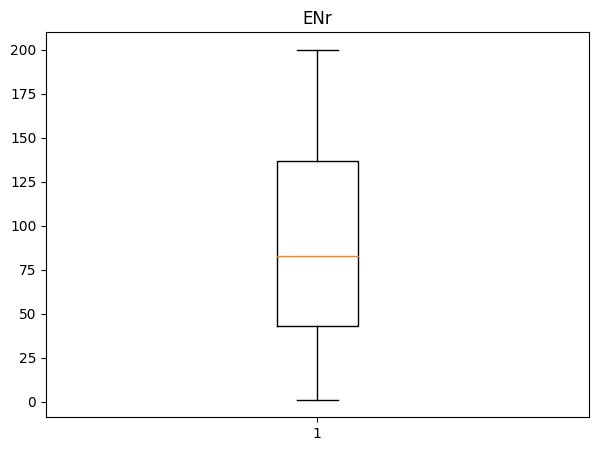

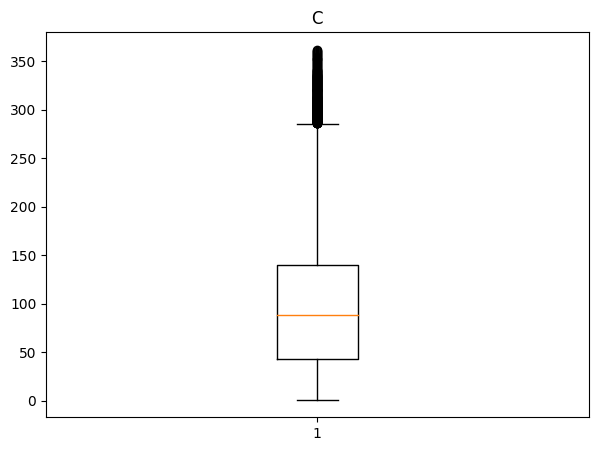

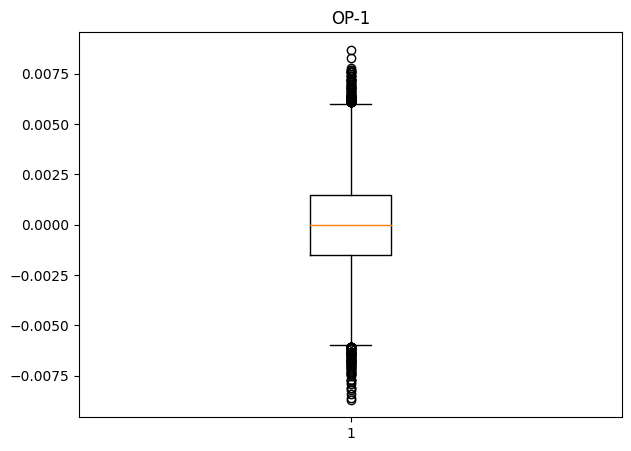

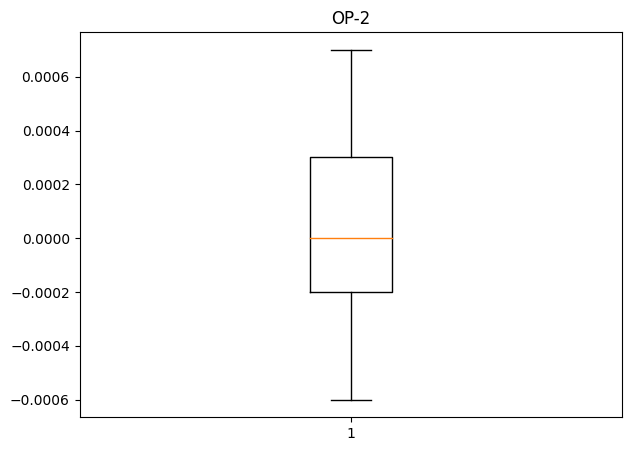

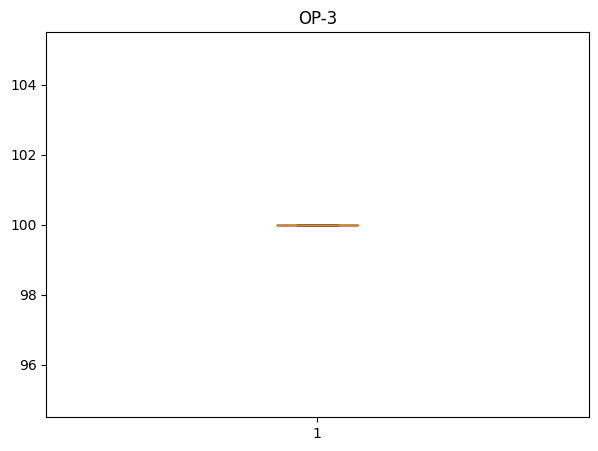

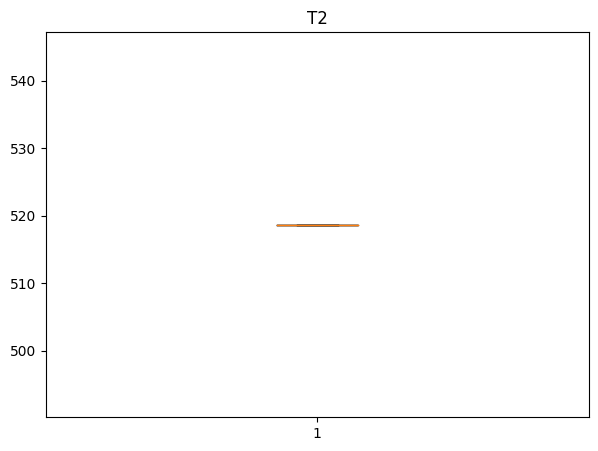

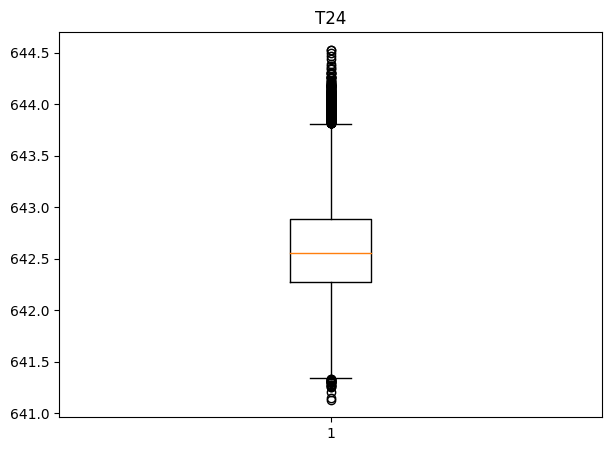

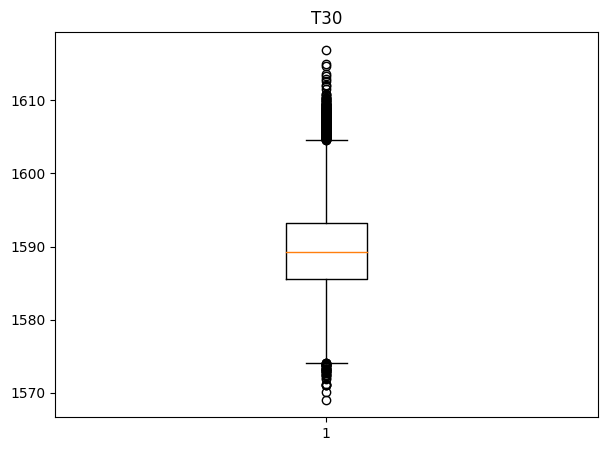

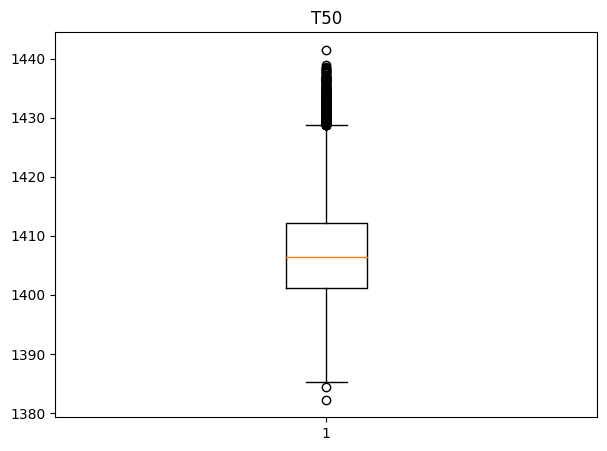

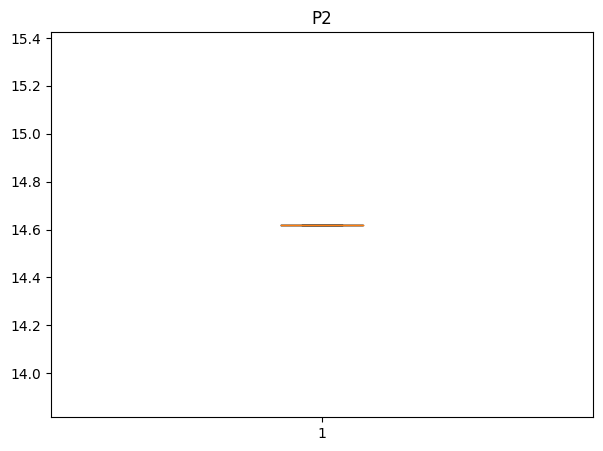

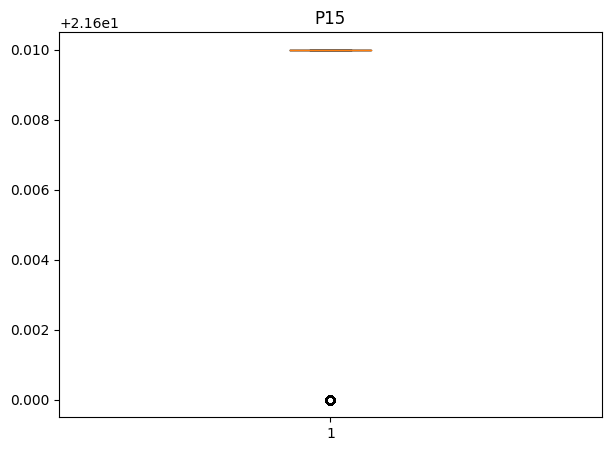

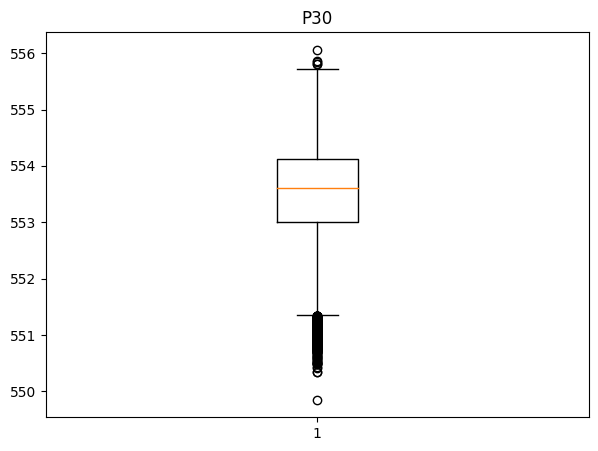

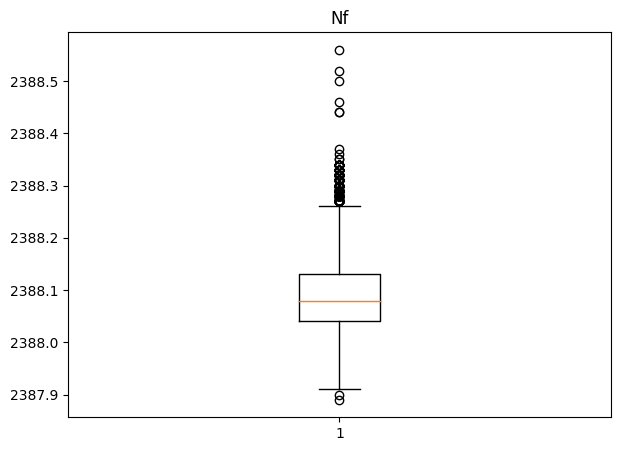

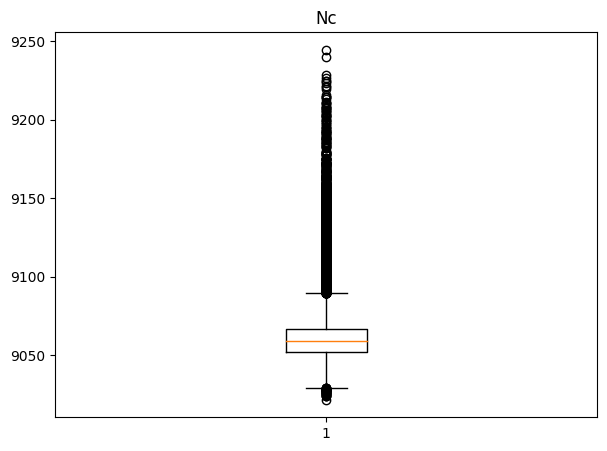

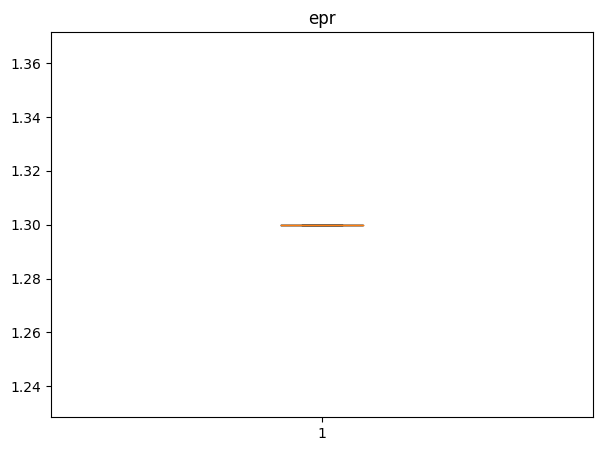

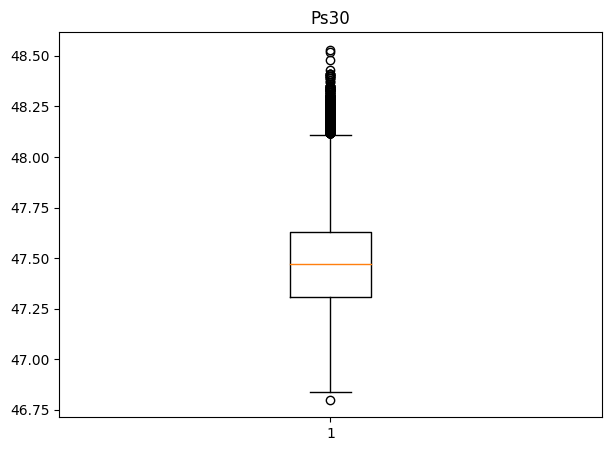

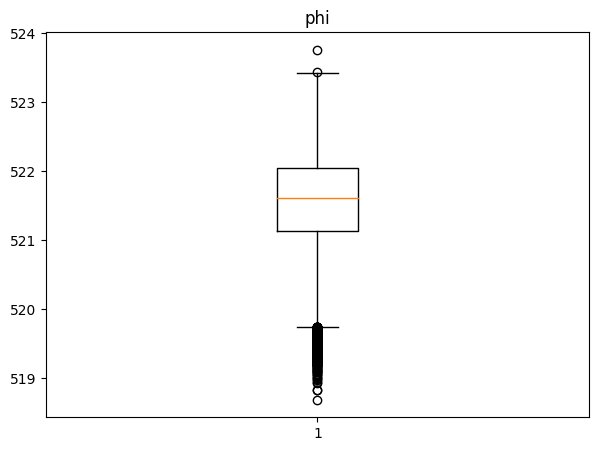

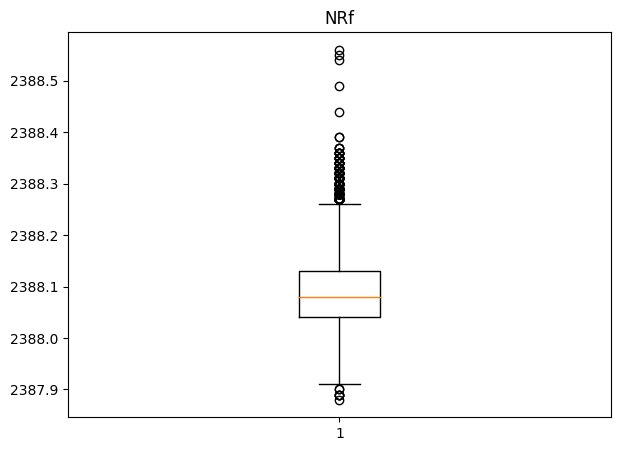

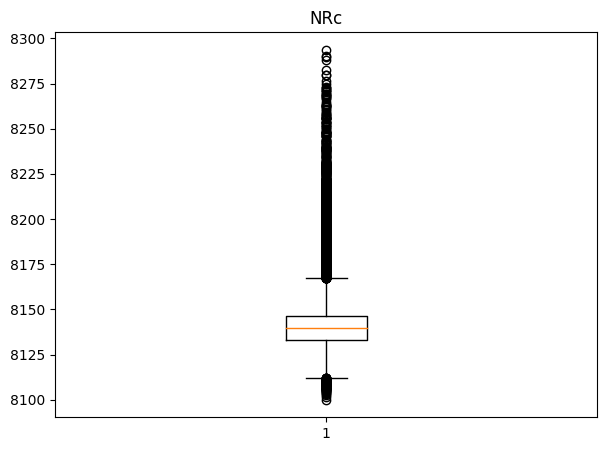

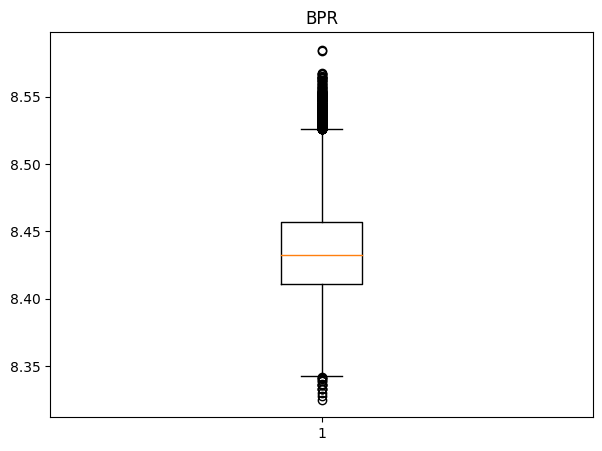

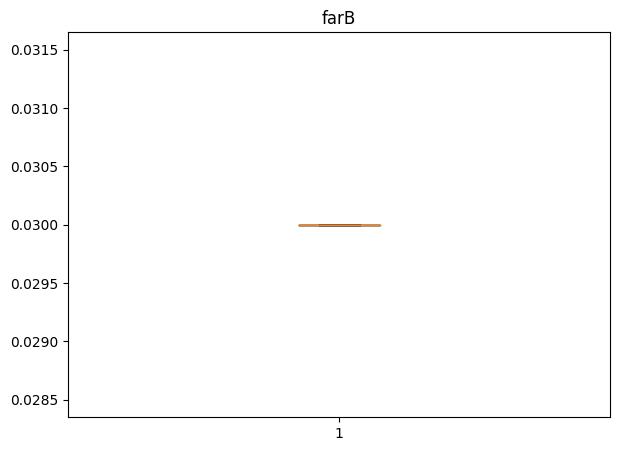

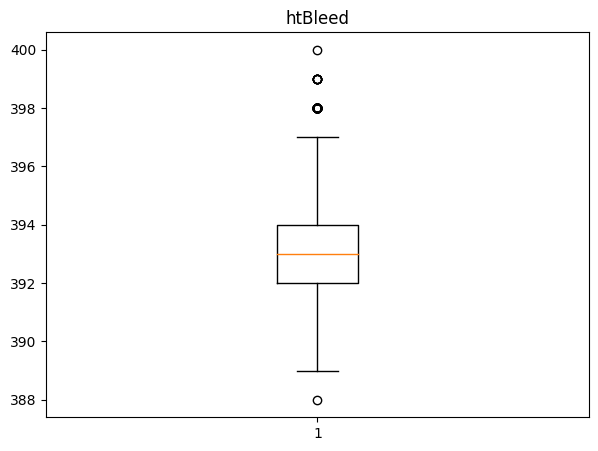

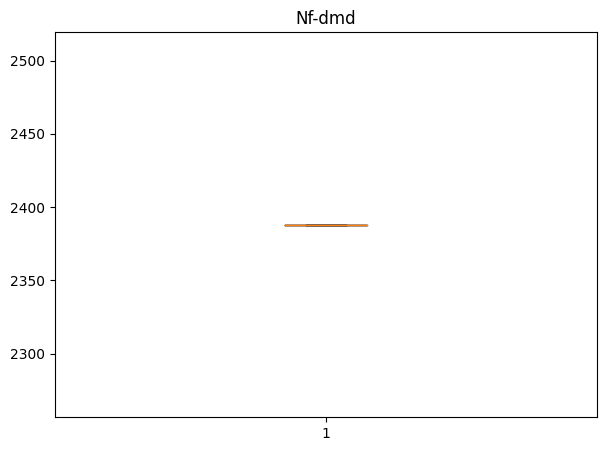

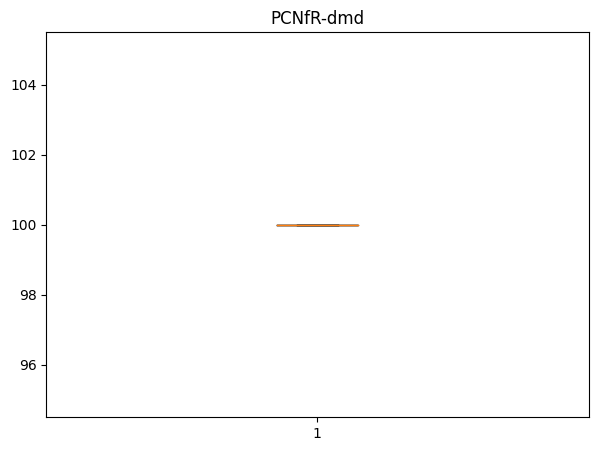

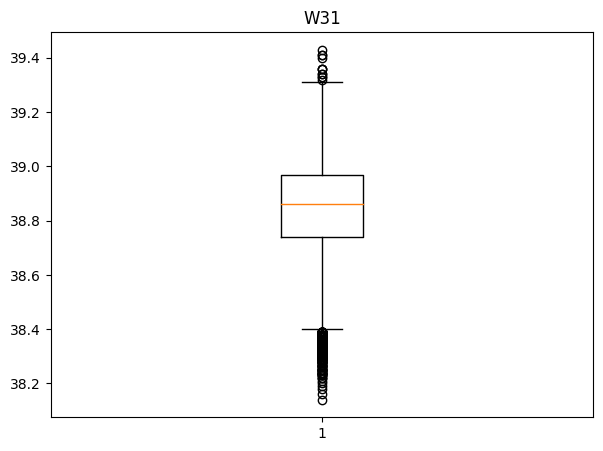

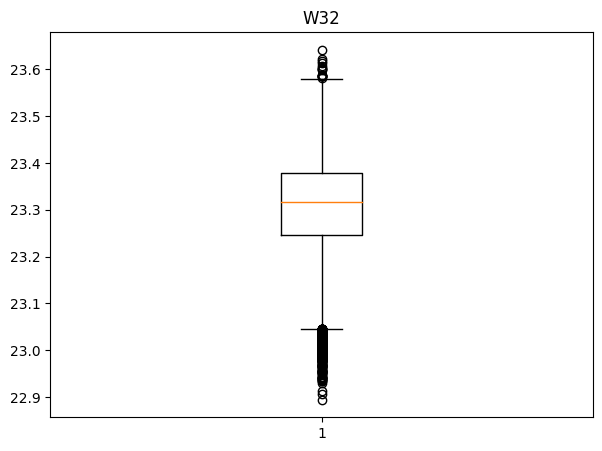

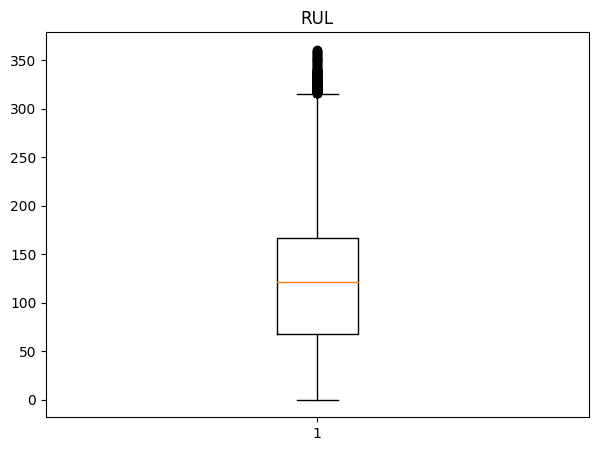

In [ ]:
boxplots(turbofan1)

**CONCLUSIONS:**

*   There are no missing or null values, but there are constant values that should be eliminated
*   The subsets have outliers => we will need to filter the data



##Subset Differences

In [ ]:
# check if there are notable differences between the testing and training sets (significant differences may affect performance)
def dataset_differences(turbo_train, turbo_test):
  features = turbo_train.iloc[:, :-1]
  target = turbo_train.iloc[:, -1]
  num_features = features.shape[1]

  features_test = turbo_test.iloc[:, :-1]
  target_test = turbo_test.iloc[:, -1]

  fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 6*num_features))

  for i in range(num_features):
      ax = axes[i]
      ax.scatter(features.iloc[:, i], target, color='purple', alpha=0.5, label='Train Set')
      ax.scatter(features_test.iloc[:, i], target_test, color='coral', alpha=0.5, label='Test Set')
      ax.set_xlabel('Feature ' + str(i+1))
      ax.set_ylabel('Target')
      ax.legend()

  plt.tight_layout()
  plt.show()

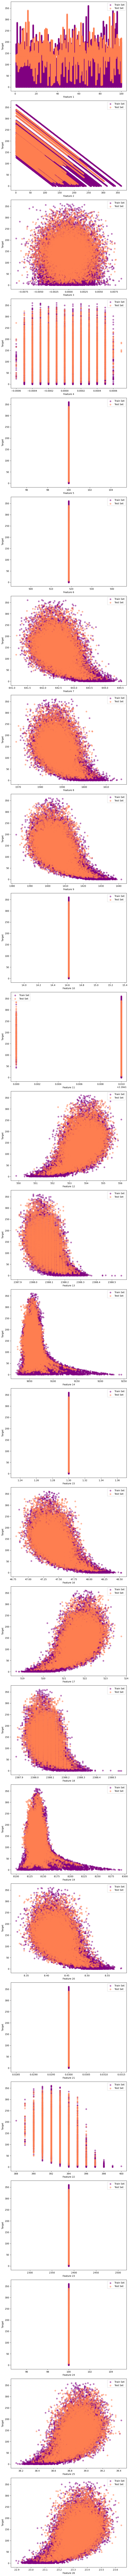

In [ ]:
dataset_differences(turbo_train_1, turbo_test_1)

**CONCLUSION**: No significant differences found

##Bivariate - Correlation Analysis

In [ ]:
#compute the Pearson Correlation Coefficient (Pearson r) between the attributes and RUL
def compute_pearson(turbofan):
  correlation_matrix = turbofan.corr(method='pearson')*100
  target_column = 'RUL'
  correlation = correlation_matrix[target_column]
  return round(correlation, 3)

In [ ]:
p1=compute_pearson(turbofan1)
p2=compute_pearson(turbofan2)
p3=compute_pearson(turbofan3)
p4=compute_pearson(turbofan4)

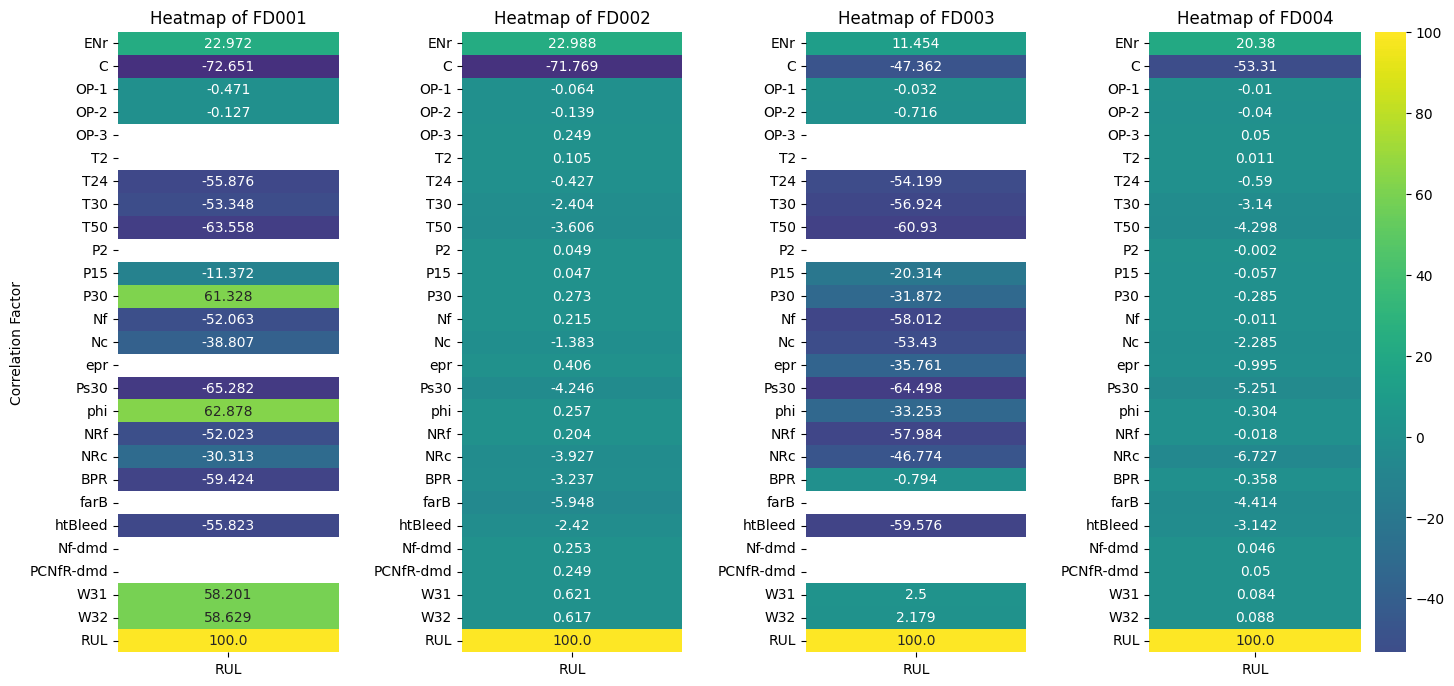

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

sns.heatmap(p1.to_frame(), annot=True, center=0, cmap='viridis', fmt='', ax=axs[0], cbar=False)
axs[0].set_title('Heatmap of FD001')
axs[0].set_ylabel('Correlation Factor')

sns.heatmap(p2.to_frame(), annot=True, center=0, cmap='viridis', fmt='', ax=axs[1], cbar=False)
axs[1].set_title('Heatmap of FD002')

sns.heatmap(p3.to_frame(), annot=True, center=0, cmap='viridis', fmt='', ax=axs[2], cbar=False)
axs[2].set_title('Heatmap of FD003')

sns.heatmap(p4.to_frame(), annot=True, center=0, cmap='viridis', fmt='', ax=axs[3])
axs[3].set_title('Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=2.5)

plt.show()

In [ ]:
#plot the complete heatmap for all subsets (all attribute pairs will be compared)
def all_correlations(turbofan):
  correlation_matrix = turbofan.corr(method='pearson')
  return round(correlation_matrix, 2)

In [ ]:
pear1=all_correlations(turbofan1)
pear2=all_correlations(turbofan2)
pear3=all_correlations(turbofan3)
pear4=all_correlations(turbofan4)

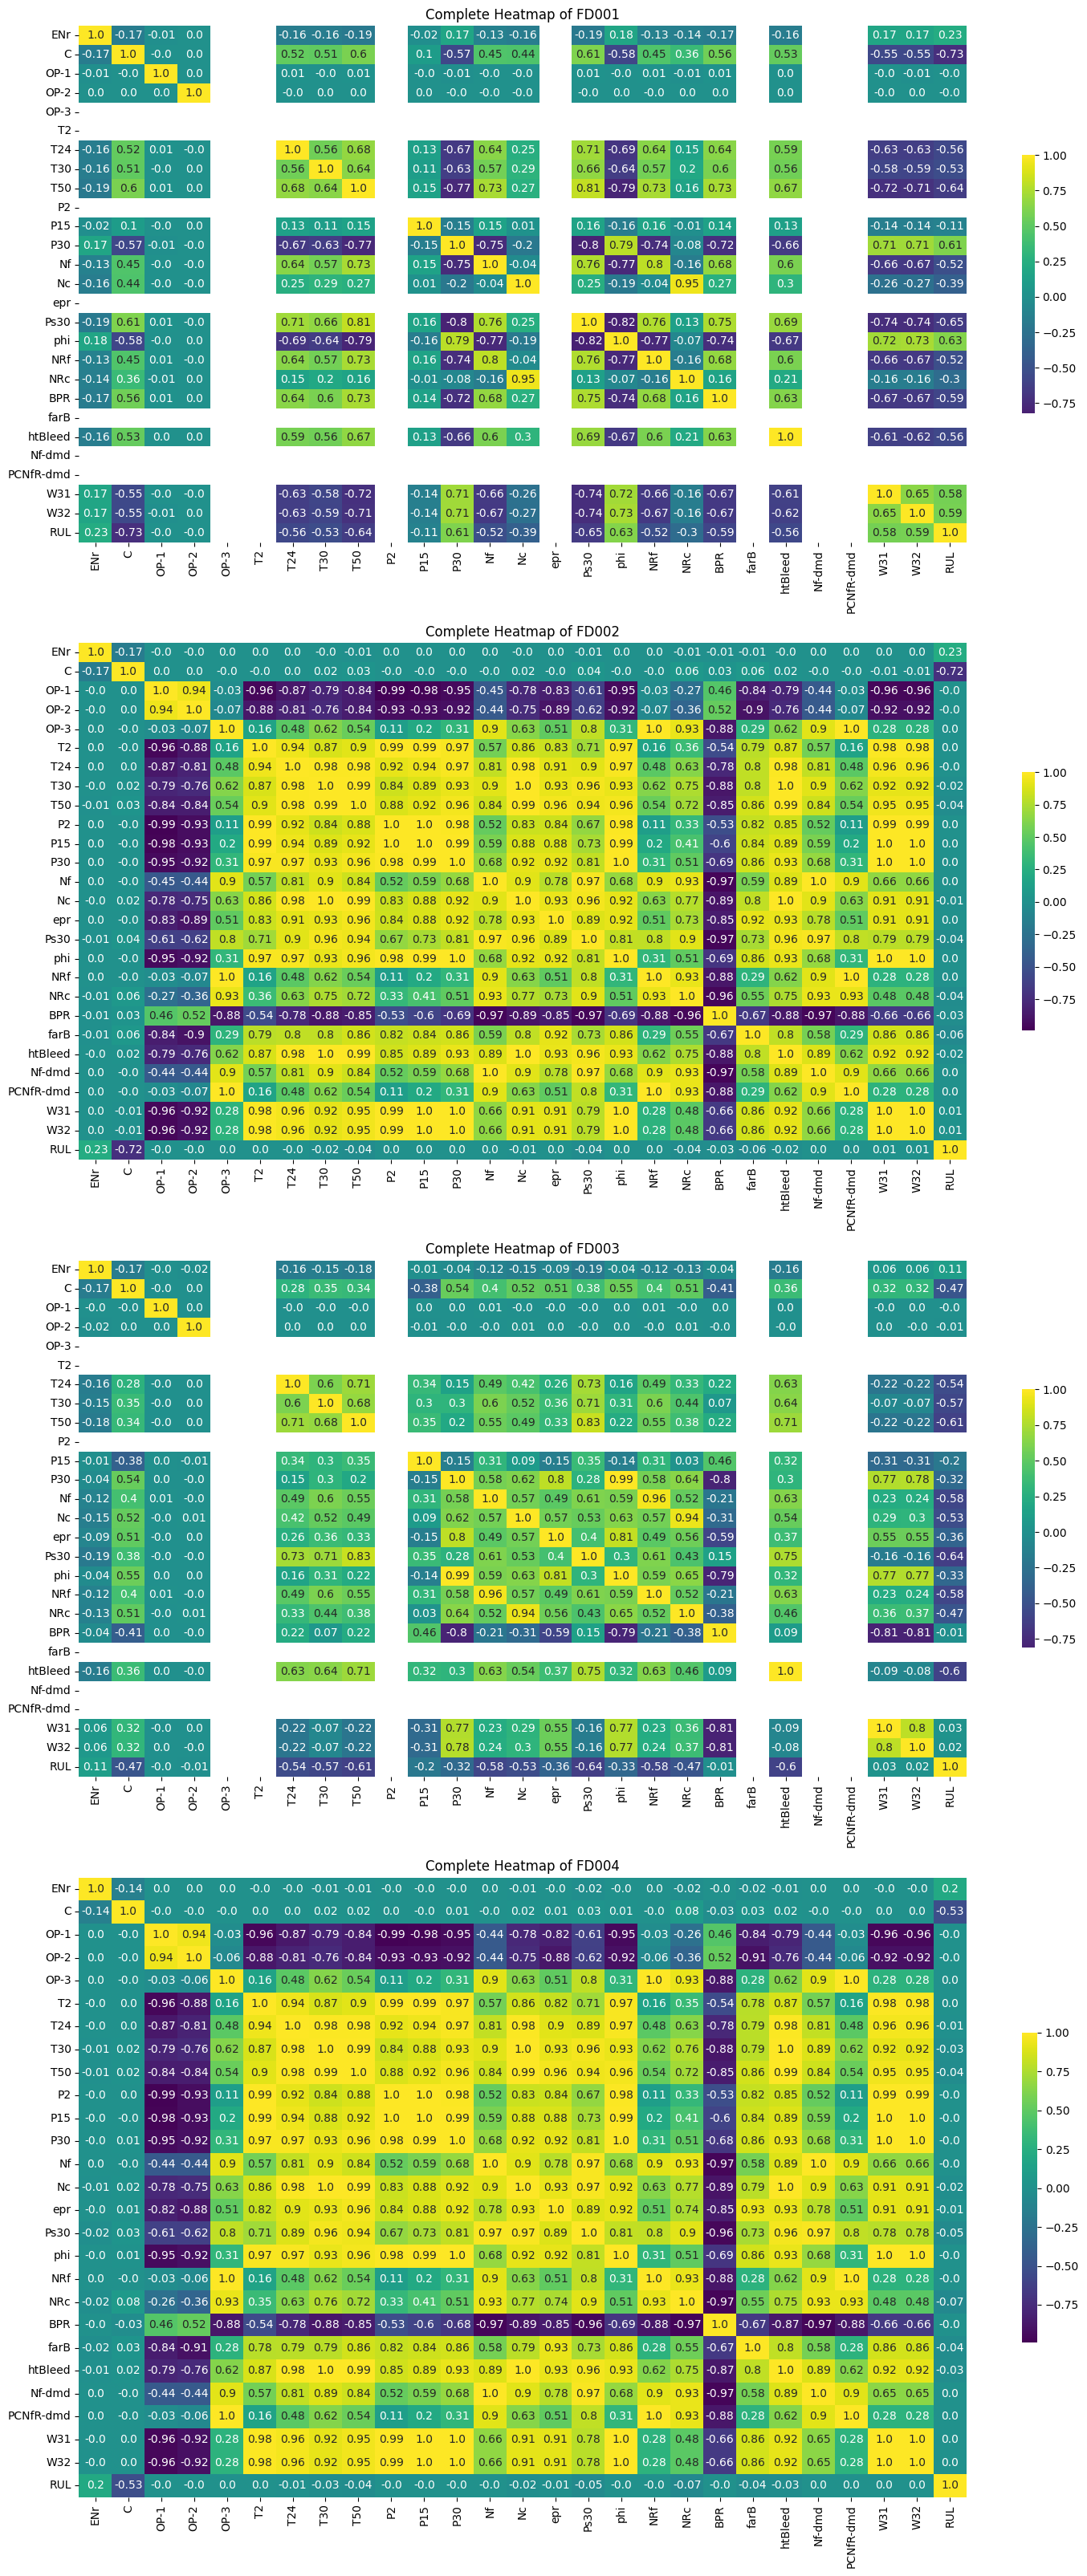

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 35), gridspec_kw={'height_ratios': [1, 1, 1, 1.2]})

sns.heatmap(pear1, annot=True, center=0, cmap='viridis', fmt='', ax=axs[0], cbar_kws={"shrink": .5})
axs[0].set_title('Complete Heatmap of FD001')

sns.heatmap(pear2, annot=True, center=0, cmap='viridis', fmt='', ax=axs[1], cbar_kws={"shrink": .5})
axs[1].set_title('Complete Heatmap of FD002')

sns.heatmap(pear3, annot=True, center=0, cmap='viridis', fmt='', ax=axs[2], cbar_kws={"shrink": .5})
axs[2].set_title('Complete Heatmap of FD003')

sns.heatmap(pear4, annot=True, center=0, cmap='viridis', fmt='', ax=axs[3], cbar_kws={"shrink": .5})
axs[3].set_title('Complete Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [ ]:
# find the sensors with 1.0 (maximum) correlation
sensor_pairs = []
for i, pear in enumerate([pear1, pear2, pear3, pear4], start=1):
    for sensor1, row in pear.iterrows():
        for sensor2, correlation in row.items():
            if correlation == 1 and sensor1 != sensor2:
                sensor_pairs.append((f'FD00{i}_{sensor1}', f'FD00{i}_{sensor2}'))

sensor_pairs_list= pd.DataFrame(sensor_pairs, columns=['Sensor1', 'Sensor2'])

In [ ]:
sensor_pairs_list

Sensor1          Sensor2
0   FD002_OP-3        FD002_NRf
1   FD002_OP-3  FD002_PCNfR-dmd
2    FD002_T30         FD002_Nc
3    FD002_T30    FD002_htBleed
4     FD002_P2        FD002_P15
..         ...              ...
59   FD004_W31        FD004_W32
60   FD004_W32        FD004_P15
61   FD004_W32        FD004_P30
62   FD004_W32        FD004_phi
63   FD004_W32        FD004_W31

[64 rows x 2 columns]

In [ ]:
# exclusions based on Correlation Analysis (we keep the attribute with higher RUL correlation between the 2)
columns_to_drop1 = ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf-dmd', 'PCNfR-dmd']
columns_to_drop3 = ['T2', 'P2', 'epr', 'farB', 'Nf-dmd', 'PCNfR-dmd']

In [ ]:
columns_to_drop2=['NRf', 'T30', 'Nc', 'P15', 'P30', 'phi', 'W32', 'Nf']
columns_to_drop4=['NRf', 'T30', 'Nc', 'P2', 'W31', 'P30', 'phi', 'Nf']

In [ ]:
turbofan1.drop(columns=columns_to_drop1, inplace=True)
turbofan3.drop(columns=columns_to_drop3, inplace=True)

In [ ]:
turbofan2.drop(columns=columns_to_drop2, inplace=True)
turbofan4.drop(columns=columns_to_drop4, inplace=True)

In [ ]:
turbofan1

ENr    C    OP-1    OP-2   OP-3     T24      T30      T50     P30  \
0        1    1 -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36   
1        1    2  0.0019 -0.0003  100.0  642.15  1591.82  1403.14  553.75   
2        1    3 -0.0043  0.0003  100.0  642.35  1587.99  1404.20  554.26   
3        1    4  0.0007  0.0000  100.0  642.35  1582.79  1401.87  554.45   
4        1    5 -0.0019 -0.0002  100.0  642.37  1582.85  1406.22  554.00   
...    ...  ...     ...     ...    ...     ...      ...      ...     ...   
33722  200  194  0.0049  0.0000  100.0  643.24  1599.45  1415.79  553.41   
33723  200  195 -0.0011 -0.0001  100.0  643.22  1595.69  1422.05  553.22   
33724  200  196 -0.0006 -0.0003  100.0  643.44  1593.15  1406.82  553.04   
33725  200  197 -0.0038  0.0001  100.0  643.26  1594.99  1419.36  553.37   
33726  200  198  0.0013  0.0003  100.0  642.95  1601.62  1424.99  552.48   

            Nf       Nc   Ps30     phi      NRf      NRc     BPR  htBleed  \
0      2388.06  9046.19  47.47  521.66  2388.02  8138.62  8.4195      392   
1      2388.04  9044.07  47.49  522.28  2388.07  8131.49  8.4318      392   
2      2388.08  9052.94  47.27  522.42  2388.03  8133.23  8.4178      390   
3      2388.11  9049.48  47.13  522.86  2388.08  8133.83  8.3682      392   
4      2388.06  9055.15  47.28  522.19  2388.04  8133.80  8.4294      393   
...        ...      ...    ...     ...      ...      ...     ...      ...   
33722  2388.02  9142.37  47.69  520.69  2388.00  8213.28  8.4715      394   
33723  2388.05  9140.68  47.60  521.05  2388.09  8210.85  8.4512      395   
33724  2388.11  9146.81  47.57  521.18  2388.04  8217.24  8.4569      395   
33725  2388.07  9148.85  47.61  521.33  2388.08  8220.48  8.4711      395   
33726  2388.06  9155.03  47.80  521.07  2388.05  8214.64  8.4903      396   

         W31      W32  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
33722  38.65  23.1974   24  
33723  38.57  23.2771   23  
33724  38.62  23.2051   22  
33725  38.66  23.2699   21  
33726  38.70  23.1855   20  

[33727 rows x 20 columns]

#Preprocessing

##Filtering

In [ ]:
!pip install statsmodels

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing

In [ ]:
def exponential_smoothing(turbofan, smoothing_level):
    columns_to_exclude = ['ENr', 'C', 'RUL', 'OP-1', 'OP-2', 'OP-3']
    columns_to_smooth = turbofan.columns.difference(columns_to_exclude)

    smoothed_turbofan = turbofan.copy()

    for column in columns_to_smooth:
        smoothed_turbofan[column] = turbofan.groupby('ENr')[column].apply(
            lambda x: SimpleExpSmoothing(x, initialization_method="heuristic").fit(
                smoothing_level=smoothing_level, optimized=False
            ).fittedvalues
        ).reset_index(level=0, drop=True)

    return smoothed_turbofan

In [ ]:
filtered_turbo1=exponential_smoothing(turbofan1, 0.1)
filtered_turbo2=exponential_smoothing(turbofan2, 0.1)
filtered_turbo3=exponential_smoothing(turbofan3, 0.1)
filtered_turbo4=exponential_smoothing(turbofan4, 0.1)

In [ ]:
filtered_turbo1

ENr    C    OP-1    OP-2   OP-3         T24          T30          T50  \
0        1    1 -0.0007 -0.0004  100.0  642.202000  1587.277333  1404.038000   
1        1    2  0.0019 -0.0003  100.0  642.163800  1587.519600  1403.694200   
2        1    3 -0.0043  0.0003  100.0  642.162420  1587.949640  1403.638780   
3        1    4  0.0007  0.0000  100.0  642.181178  1587.953676  1403.694902   
4        1    5 -0.0019 -0.0002  100.0  642.198060  1587.437308  1403.512412   
...    ...  ...     ...     ...    ...         ...          ...          ...   
33722  200  194  0.0049  0.0000  100.0  642.873126  1593.387101  1413.530015   
33723  200  195 -0.0011 -0.0001  100.0  642.909814  1593.993391  1413.756014   
33724  200  196 -0.0006 -0.0003  100.0  642.940832  1594.163052  1414.585412   
33725  200  197 -0.0038  0.0001  100.0  642.990749  1594.061747  1413.808871   
33726  200  198  0.0013  0.0003  100.0  643.017674  1594.154572  1414.363984   

              P30           Nf           Nc       Ps30         phi  \
0      554.398000  2388.073333  9048.590000  47.436667  522.284000   
1      554.394200  2388.072000  9048.350000  47.440000  522.221600   
2      554.329780  2388.068800  9047.922000  47.445000  522.227440   
3      554.322802  2388.069920  9048.423800  47.427500  522.246696   
4      554.335522  2388.073928  9048.529420  47.397750  522.308026   
...           ...          ...          ...        ...         ...   
33722  553.376115  2388.046223  9126.035005  47.590560  521.484661   
33723  553.379504  2388.043601  9127.668505  47.600504  521.405195   
33724  553.363553  2388.044241  9128.969654  47.600454  521.369675   
33725  553.331198  2388.050817  9130.753689  47.597408  521.350708   
33726  553.335078  2388.052735  9132.563320  47.598668  521.348637   

               NRf          NRc       BPR     htBleed        W31        W32  \
0      2388.042000  8136.896000  8.418827  391.400000  38.977333  23.384947   
1      2388.039800  8137.068400  8.418894  391.460000  38.985600  23.388352   
2      2388.042820  8136.510560  8.420185  391.514000  38.987040  23.391877   
3      2388.041538  8136.182504  8.419946  391.362600  38.983336  23.387109   
4      2388.045384  8135.947254  8.414772  391.426340  38.973002  23.385788   
...            ...          ...       ...         ...        ...        ...   
33722  2388.048958  8198.221641  8.450965  394.031053  38.781093  23.287730   
33723  2388.044063  8199.727477  8.453019  394.027948  38.767984  23.278697   
33724  2388.048656  8200.839729  8.452837  394.125153  38.748185  23.278537   
33725  2388.047791  8202.479756  8.453243  394.212638  38.735367  23.271193   
33726  2388.051012  8204.279781  8.455029  394.291374  38.727830  23.271064   

       RUL  
0      191  
1      190  
2      189  
3      188  
4      187  
...    ...  
33722   24  
33723   23  
33724   22  
33725   21  
33726   20  

[33727 rows x 20 columns]

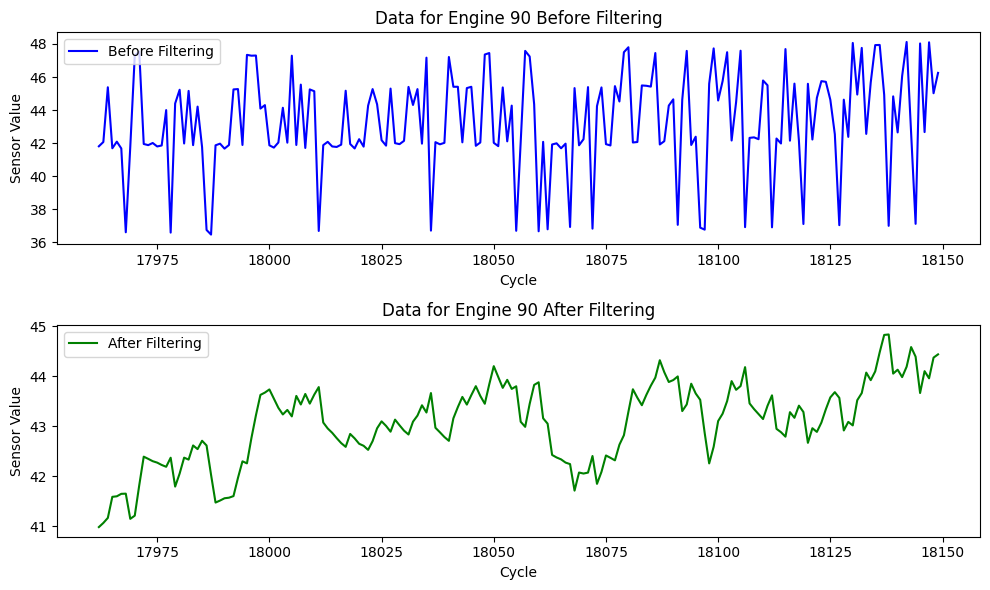

In [ ]:
def before_and_after(turbofan, filtered_turbo, engine_number):
    engine_data_before = turbofan[turbofan['ENr'] == engine_number]
    engine_data_after = filtered_turbo[filtered_turbo['ENr'] == engine_number]

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(engine_data_before['Ps30'], label='Before Filtering', color='blue')
    plt.title(f'Data for Engine {engine_number} Before Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(engine_data_after['Ps30'], label='After Filtering', color='green')
    plt.title(f'Data for Engine {engine_number} After Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

engine_number = 90
before_and_after(turbofan2, filtered_turbo2, engine_number)

##Normalization

In [ ]:
# perform z-score normalization (standardization)
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C', 'RUL'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [ ]:
normalized_turbo1=z_score(filtered_turbo1)
normalized_turbo2=z_score(filtered_turbo2)
normalized_turbo3=z_score(filtered_turbo3)
normalized_turbo4=z_score(filtered_turbo4)

In [ ]:
normalized_turbo1

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
0        1    1 -0.314711 -1.373690   0.0 -1.060997 -0.460301 -0.354106   
1        1    2  0.870755 -1.032895   0.0 -1.174896 -0.397975 -0.405491   
2        1    3 -1.956125  1.011877   0.0 -1.179011 -0.287342 -0.413774   
3        1    4  0.323617 -0.010509   0.0 -1.123081 -0.286303 -0.405386   
4        1    5 -0.861849 -0.692099   0.0 -1.072744 -0.419145 -0.432661   
...    ...  ...       ...       ...   ...       ...       ...       ...   
33722  200  194  2.238601 -0.010509   0.0  0.940079  1.111509  1.064589   
33723  200  195 -0.497090 -0.351304   0.0  1.049468  1.267484  1.098367   
33724  200  196 -0.269116 -1.032895   0.0  1.141956  1.311131  1.222330   
33725  200  197 -1.728151  0.330287   0.0  1.290791  1.285069  1.106267   
33726  200  198  0.597186  1.011877   0.0  1.371073  1.308950  1.189235   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
0      1.192710 -0.132586 -0.824584 -0.139226  1.176078 -0.688611 -0.303931   
1      1.187000 -0.156628 -0.840140 -0.123040  1.066125 -0.728092 -0.291183   
2      1.090207 -0.214328 -0.867882 -0.098760  1.076416 -0.673896 -0.332431   
3      1.079722 -0.194133 -0.835357 -0.183737  1.110346 -0.696902 -0.356688   
4      1.098834 -0.121864 -0.828511 -0.328198  1.218414 -0.627879 -0.374083   
...         ...       ...       ...       ...       ...       ...       ...   
33722 -0.342708 -0.621418  4.195256  0.608052 -0.232407 -0.563737  4.230632   
33723 -0.337616 -0.668701  4.301137  0.656338 -0.372431 -0.651597  4.341977   
33724 -0.361582 -0.657163  4.385475  0.656094 -0.435019 -0.569159  4.424220   
33725 -0.410197 -0.538591  4.501112  0.641306 -0.468441 -0.584693  4.545487   
33726 -0.404367 -0.504001  4.618409  0.647420 -0.472089 -0.526891  4.678585   

            BPR   htBleed       W31       W32  RUL  
0     -0.510671 -1.387005  0.907088  0.897956  191  
1     -0.508122 -1.328482  0.972650  0.943278  190  
2     -0.459269 -1.275811  0.984070  0.990191  189  
3     -0.468296 -1.423485  0.954694  0.926736  188  
4     -0.664169 -1.361314  0.872739  0.909156  187  
...         ...       ...       ...       ...  ...  
33722  0.705859  1.179286 -0.649273 -0.395934   24  
33723  0.783589  1.176257 -0.753242 -0.516156   23  
33724  0.776705  1.271069 -0.910261 -0.518281   22  
33725  0.792086  1.356401 -1.011923 -0.616021   21  
33726  0.859680  1.433199 -1.071696 -0.617742   20  

[33727 rows x 20 columns]

##Damage Modeling

In [ ]:
#split dataframe into train and test (only train is needed for damage modeling)
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [ ]:
turbo1_train, turbo1_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_train, turbo2_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_train, turbo3_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_train, turbo4_test=split_dataframe(normalized_turbo4, nr_train_4)

In [ ]:
turbo1_train

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
0        1    1 -0.314711 -1.373690   0.0 -1.060997 -0.460301 -0.354106   
1        1    2  0.870755 -1.032895   0.0 -1.174896 -0.397975 -0.405491   
2        1    3 -1.956125  1.011877   0.0 -1.179011 -0.287342 -0.413774   
3        1    4  0.323617 -0.010509   0.0 -1.123081 -0.286303 -0.405386   
4        1    5 -0.861849 -0.692099   0.0 -1.072744 -0.419145 -0.432661   
...    ...  ...       ...       ...   ...       ...       ...       ...   
20626  100  196 -0.177926 -1.032895   0.0  2.480738  2.547181  2.657356   
20627  100  197 -0.725065 -1.714485   0.0  2.510603  2.521771  2.723766   
20628  100  198  0.186832 -0.010509   0.0  2.552390  2.666637  2.857519   
20629  100  199 -0.497090  1.011877   0.0  2.554219  2.744535  2.897188   
20630  100  200 -1.454582 -1.714485   0.0  2.499213  2.886677  2.908228   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
0      1.192710 -0.132586 -0.824584 -0.139226  1.176078 -0.688611 -0.303931   
1      1.187000 -0.156628 -0.840140 -0.123040  1.066125 -0.728092 -0.291183   
2      1.090207 -0.214328 -0.867882 -0.098760  1.076416 -0.673896 -0.332431   
3      1.079722 -0.194133 -0.835357 -0.183737  1.110346 -0.696902 -0.356688   
4      1.098834 -0.121864 -0.828511 -0.328198  1.218414 -0.627879 -0.374083   
...         ...       ...       ...       ...       ...       ...       ...   
20626 -2.777740  2.414243  0.365337  2.803882 -2.644143  2.521668  0.046801   
20627 -2.826647  2.369923  0.356082  2.817106 -2.754441  2.591857  0.016934   
20628 -2.956308  2.402161  0.345095  2.814440 -2.820230  2.583244 -0.018081   
20629 -3.060983  2.449205  0.340327  2.836320 -2.821292  2.611384 -0.015950   
20630 -3.194256  2.509577  0.386724  3.001686 -2.882158  2.618764 -0.027046   

            BPR   htBleed       W31       W32  RUL  
0     -0.510671 -1.387005  0.907088  0.897956  191  
1     -0.508122 -1.328482  0.972650  0.943278  190  
2     -0.459269 -1.275811  0.984070  0.990191  189  
3     -0.468296 -1.423485  0.954694  0.926736  188  
4     -0.664169 -1.361314  0.872739  0.909156  187  
...         ...       ...       ...       ...  ...  
20626  2.820191  2.586245 -3.093225 -2.551413    4  
20627  2.777713  2.735136 -3.079692 -2.754083    3  
20628  2.808754  2.674061 -3.218200 -2.689066    2  
20629  3.028604  2.911708 -3.231825 -2.931473    1  
20630  3.129188  2.832976 -3.363050 -2.975687    0  

[20631 rows x 20 columns]

In [ ]:
!pip install pwlf

0.03229911431604286


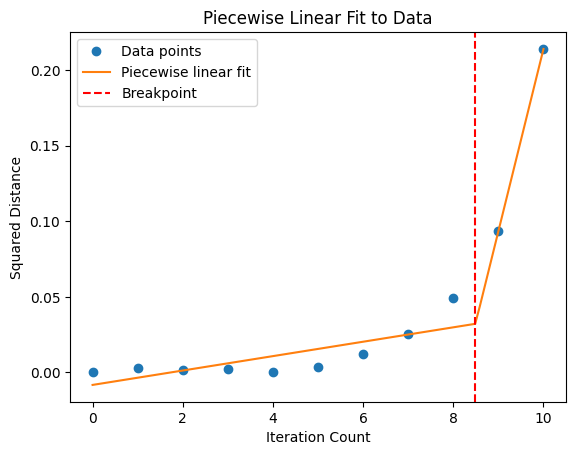

57


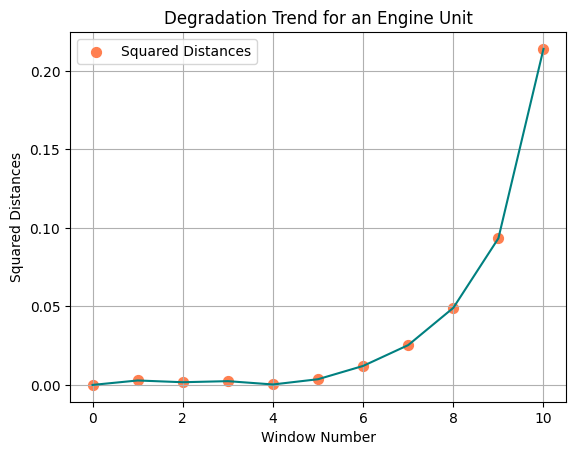

In [ ]:
import pwlf


engine_sensors = normalized_turbo1[normalized_turbo1['ENr'] == 61]
eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
engine_values=eng_sens.values

N = len(engine_sensors)
window_length = 16
iteration_counts = []
centroids=[]
mean_centroids=[]
sq=[]
iruls=[]


windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

for window in windows:
  centroid=window.mean()
  centroids.append(centroid)
  mean_centroid=centroid.mean()
  mean_centroids.append(mean_centroid)

for i in range(len(windows)-1):
  s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
  squared= s**2
  sq.append(squared)
  iteration_counts.append(i)

pw_fit = pwlf.PiecewiseLinFit(iteration_counts, sq)
breaks = pw_fit.fit(2)
intersection_x = breaks[1]
intersection_y = pw_fit.predict([intersection_x])

threshold=float(intersection_y[0])
print(threshold)


#visualization of the breakpoint
pwlf_model = pwlf.PiecewiseLinFit(iteration_counts, sq)
breaks = pwlf_model.fit(2)

x_hat = np.linspace(min(iteration_counts), max(iteration_counts), 100)
y_hat = pwlf_model.predict(x_hat)

plt.plot(iteration_counts, sq, 'o', label='Data points')
plt.plot(x_hat, y_hat, '-', label='Piecewise linear fit')
plt.axvline(x=breaks[1], color='r', linestyle='--', label='Breakpoint')
plt.xlabel('Iteration Count')
plt.ylabel('Squared Distance')
plt.title('Piecewise Linear Fit to Data')
plt.legend()
plt.show()

#compare with encountered threshold
for i in range(len(windows)-1):
  if sq[i]>=threshold:
    irul=N-window_length*i
    iruls.append(irul)
  else:
    i=i+1

print(max(iruls))


plt.scatter(range(len(sq)), sq, color='coral', label='Squared Distances', s=50)
plt.xlabel('Window Number')
plt.ylabel('Squared Distances')
plt.title('Degradation Trend for an Engine Unit')
plt.legend()
plt.grid(True)


plt.plot(range(len(sq)), sq, color='teal', linestyle='-')

In [ ]:
def threshold_selection(normalized_turbo, nr_eng, window_length):
    thresh = []
    np.random.seed(42)
    for i in range(1, nr_eng):
        engine_sensors = normalized_turbo[normalized_turbo['ENr'] == i]
        eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
        engine_values = eng_sens.values

        iteration_counts = []
        centroids = []
        mean_centroids = []
        sq = []

        windows = [engine_values[j:j+window_length] for j in range(0, len(engine_values), window_length)]

        for window in windows:
            centroid = window.mean()
            centroids.append(centroid)
            mean_centroid = centroid.mean()
            mean_centroids.append(mean_centroid)

        for j in range(len(windows) - 1):
            s = np.sqrt(np.sum((mean_centroids[j] - mean_centroids[0])**2))
            squared = s**2
            sq.append(squared)
            iteration_counts.append(j)

        pw_fit = pwlf.PiecewiseLinFit(iteration_counts, sq)
        breaks = pw_fit.fit(2)
        intersection_x = breaks[1]
        intersection_y = pw_fit.predict([intersection_x])

        th = float(intersection_y[0])
        thresh.append(th)

    positive_thresh = [t for t in thresh if t > 0]

    if positive_thresh:
        threshold = min(positive_thresh)
    else:
        threshold = None

    return threshold


In [ ]:
th1=threshold_selection(normalized_turbo1, nr_train_1, 16)
th2=threshold_selection(normalized_turbo2, nr_train_2, 16)
th3=threshold_selection(normalized_turbo3, nr_train_3, 16)
th4=threshold_selection(normalized_turbo4, nr_train_4, 16)

In [ ]:
print("Threshold for FD001:", th1)
print("Threshold for FD002:", th2)
print("Threshold for FD003:", th3)
print("Threshold for FD004:", th4)

Threshold for FD001: 0.0009267220043713553
Threshold for FD002: 0.01670593092741814
Threshold for FD003: 0.0036441628898296516
Threshold for FD004: 0.019795281680599942


In [ ]:
#apply the degradation model to all subsets
def degradation_model(normalized_turbo, nr_eng, window_length, Th):
  RULs=[]
  RUL=0
  for i in range (1, nr_eng):
    engine_sensors = normalized_turbo[normalized_turbo['ENr'] == i]
    eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
    engine_values=eng_sens.values

    N = len(engine_sensors)
    g=N/window_length
    centroids=[]
    mean_centroids=[]
    sq=[]
    iruls=[]


    windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

    for window in windows:
      centroid=window.mean()
      centroids.append(centroid)
      mean_centroid=centroid.mean()
      mean_centroids.append(mean_centroid)

    for i in range(len(windows)-1):
      s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
      squared= s**2
      sq.append(squared)
      if squared>=Th:
        irul=N-window_length*i
        iruls.append(irul)
      else:
        i=i+1

    RUL=max(iruls)
    RULs.append(RUL)
  final_RUL=min(RULs)
  return final_RUL


In [ ]:
initial_RUL1=degradation_model(normalized_turbo1, nr_train_1, 16, th1)
initial_RUL2=degradation_model(normalized_turbo2, nr_train_2, 16, th2)
initial_RUL3=degradation_model(normalized_turbo3, nr_train_3, 16, th3)
initial_RUL4=degradation_model(normalized_turbo4, nr_train_4, 16, th4)

In [ ]:
print("Minimum initial (w=12, th=0.0049) RUL for FD001:", initial_RUL1)
print("Minimum initial (w=12, th=0.01) RUL for FD002:", initial_RUL2)
print("Minimum initial (w=12, th=0.0016) RUL for FD003:", initial_RUL3)
print("Minimum initial (w=12, th=0.04) RUL for FD001:", initial_RUL4)

Minimum initial (w=12, th=0.0049) RUL for FD001: 87
Minimum initial (w=12, th=0.01) RUL for FD002: 110
Minimum initial (w=12, th=0.0016) RUL for FD003: 65
Minimum initial (w=12, th=0.04) RUL for FD001: 91


##RUL Assignation

In [ ]:
#assign the initial RUL for the training set
def RUL_train(turbo_RUL_train, initial_RUL):
  turbo_RUL_train = turbo_RUL_train.copy()
  max_cycle = turbo_RUL_train.groupby('ENr')['C'].transform('max')
  turbo_RUL_train['RUL'] = initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_train['C'] - (max_cycle - initial_RUL)
  turbo_RUL_train.loc[turbo_RUL_train['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_train

In [ ]:
turbo1_train=RUL_train(turbo1_train, initial_RUL1)

In [ ]:
turbo1_train

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
0        1    1 -0.314711 -1.373690   0.0 -1.060997 -0.460301 -0.354106   
1        1    2  0.870755 -1.032895   0.0 -1.174896 -0.397975 -0.405491   
2        1    3 -1.956125  1.011877   0.0 -1.179011 -0.287342 -0.413774   
3        1    4  0.323617 -0.010509   0.0 -1.123081 -0.286303 -0.405386   
4        1    5 -0.861849 -0.692099   0.0 -1.072744 -0.419145 -0.432661   
...    ...  ...       ...       ...   ...       ...       ...       ...   
20626  100  196 -0.177926 -1.032895   0.0  2.480738  2.547181  2.657356   
20627  100  197 -0.725065 -1.714485   0.0  2.510603  2.521771  2.723766   
20628  100  198  0.186832 -0.010509   0.0  2.552390  2.666637  2.857519   
20629  100  199 -0.497090  1.011877   0.0  2.554219  2.744535  2.897188   
20630  100  200 -1.454582 -1.714485   0.0  2.499213  2.886677  2.908228   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
0      1.192710 -0.132586 -0.824584 -0.139226  1.176078 -0.688611 -0.303931   
1      1.187000 -0.156628 -0.840140 -0.123040  1.066125 -0.728092 -0.291183   
2      1.090207 -0.214328 -0.867882 -0.098760  1.076416 -0.673896 -0.332431   
3      1.079722 -0.194133 -0.835357 -0.183737  1.110346 -0.696902 -0.356688   
4      1.098834 -0.121864 -0.828511 -0.328198  1.218414 -0.627879 -0.374083   
...         ...       ...       ...       ...       ...       ...       ...   
20626 -2.777740  2.414243  0.365337  2.803882 -2.644143  2.521668  0.046801   
20627 -2.826647  2.369923  0.356082  2.817106 -2.754441  2.591857  0.016934   
20628 -2.956308  2.402161  0.345095  2.814440 -2.820230  2.583244 -0.018081   
20629 -3.060983  2.449205  0.340327  2.836320 -2.821292  2.611384 -0.015950   
20630 -3.194256  2.509577  0.386724  3.001686 -2.882158  2.618764 -0.027046   

            BPR   htBleed       W31       W32  RUL  
0     -0.510671 -1.387005  0.907088  0.897956   87  
1     -0.508122 -1.328482  0.972650  0.943278   87  
2     -0.459269 -1.275811  0.984070  0.990191   87  
3     -0.468296 -1.423485  0.954694  0.926736   87  
4     -0.664169 -1.361314  0.872739  0.909156   87  
...         ...       ...       ...       ...  ...  
20626  2.820191  2.586245 -3.093225 -2.551413    4  
20627  2.777713  2.735136 -3.079692 -2.754083    3  
20628  2.808754  2.674061 -3.218200 -2.689066    2  
20629  3.028604  2.911708 -3.231825 -2.931473    1  
20630  3.129188  2.832976 -3.363050 -2.975687    0  

[20631 rows x 20 columns]

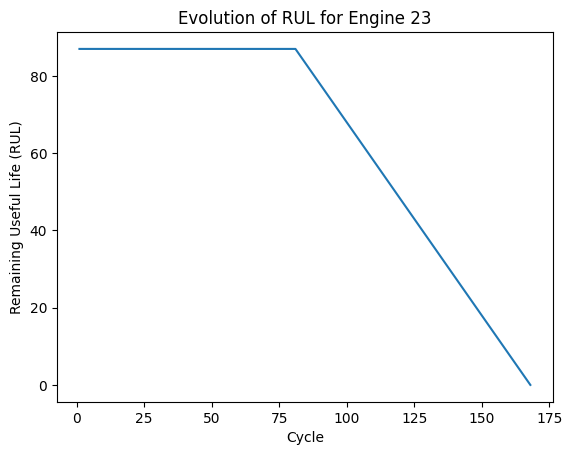

In [ ]:
#realsitic RUL trajectory
engine_number = 23
engine_df = turbo1_train[turbo1_train['ENr'] == engine_number]

plt.plot(engine_df['C'], engine_df['RUL'])
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Evolution of RUL for Engine {engine_number}')
plt.show()

In [ ]:
turbo2_train=RUL_train(turbo2_train, initial_RUL2)
turbo3_train=RUL_train(turbo3_train, initial_RUL3)
turbo4_train=RUL_train(turbo4_train, initial_RUL4)

In [ ]:
#assign RUL for the testing set
def RUL_test(turbo_RUL_test, initial_RUL, nr_train, y_RUL):
    turbo_RUL_test = turbo_RUL_test.copy()
    y_RUL_series = y_RUL[0]
    adjusted_engine_numbers = turbo_RUL_test['ENr'].values - nr_train-1
    max_cycle = turbo_RUL_test.groupby('ENr')['C'].transform('max')+ y_RUL_series.iloc[adjusted_engine_numbers].values
    turbo_RUL_test['RUL'] = initial_RUL
    turbo_RUL_test.loc[turbo_RUL_test['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_test['C'] - (max_cycle - initial_RUL)
    turbo_RUL_test.loc[turbo_RUL_test['RUL'] < 0, 'RUL'] = 0
    return turbo_RUL_test

In [ ]:
turbo1_test=RUL_test(turbo1_test, initial_RUL1, nr_train_1, y_RUL_1)

In [ ]:
turbo1_test

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
20631  101    1  1.053135  1.011877   0.0  0.016379 -0.885125 -1.270705   
20632  101    2 -1.226608 -1.032895   0.0  0.152542 -0.893769 -1.266152   
20633  101    3  0.141238  0.330287   0.0 -0.115510 -0.820254 -1.303753   
20634  101    4  1.919437 -0.010509   0.0 -0.133131 -0.792937 -1.249113   
20635  101    5  0.642781 -0.010509   0.0 -0.154954 -0.840900 -1.124011   
...    ...  ...       ...       ...   ...       ...       ...       ...   
33722  200  194  2.238601 -0.010509   0.0  0.940079  1.111509  1.064589   
33723  200  195 -0.497090 -0.351304   0.0  1.049468  1.267484  1.098367   
33724  200  196 -0.269116 -1.032895   0.0  1.141956  1.311131  1.222330   
33725  200  197 -1.728151  0.330287   0.0  1.290791  1.285069  1.106267   
33726  200  198  0.597186  1.011877   0.0  1.371073  1.308950  1.189235   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
20631  0.938281 -1.082228 -0.642099 -0.301086  0.347909 -0.784322 -0.761732   
20632  0.888897 -1.047367 -0.650106 -0.399821  0.331346 -0.796286 -0.799847   
20633  0.987193 -1.070087 -0.629765 -0.343008  0.393969 -0.753216 -0.730114   
20634  0.964472 -1.018409 -0.594994 -0.291876  0.416852 -0.768290 -0.737747   
20635  0.938013 -1.007962 -0.639343 -0.352685  0.333484 -0.745966 -0.723912   
...         ...       ...       ...       ...       ...       ...       ...   
33722 -0.342708 -0.621418  4.195256  0.608052 -0.232407 -0.563737  4.230632   
33723 -0.337616 -0.668701  4.301137  0.656338 -0.372431 -0.651597  4.341977   
33724 -0.361582 -0.657163  4.385475  0.656094 -0.435019 -0.569159  4.424220   
33725 -0.410197 -0.538591  4.501112  0.641306 -0.468441 -0.584693  4.545487   
33726 -0.404367 -0.504001  4.618409  0.647420 -0.472089 -0.526891  4.678585   

            BPR   htBleed       W31       W32  RUL  
20631 -1.237444 -0.411620  0.880651  0.908958   87  
20632 -1.216348 -0.450635  0.790239  0.892623   87  
20633 -1.291614 -0.388211  0.835762  0.902011   87  
20634 -1.117853 -0.332028  0.924319  0.943734   87  
20635 -1.159817 -0.476542  0.940572  0.924188   87  
...         ...       ...       ...       ...  ...  
33722  0.705859  1.179286 -0.649273 -0.395934   24  
33723  0.783589  1.176257 -0.753242 -0.516156   23  
33724  0.776705  1.271069 -0.910261 -0.518281   22  
33725  0.792086  1.356401 -1.011923 -0.616021   21  
33726  0.859680  1.433199 -1.071696 -0.617742   20  

[13096 rows x 20 columns]

In [ ]:
turbo2_test=RUL_test(turbo2_test, initial_RUL2, nr_train_2, y_RUL_2)
turbo3_test=RUL_test(turbo3_test, initial_RUL3, nr_train_3, y_RUL_3)
turbo4_test=RUL_test(turbo4_test, initial_RUL4, nr_train_4, y_RUL_4)

##Prepare for Training

In [ ]:
drop_op_sett = ['OP-1', 'OP-2', 'OP-3']
turbo1_train.drop(columns=drop_op_sett, inplace=True)
turbo1_test.drop(columns=drop_op_sett, inplace=True)

turbo3_train.drop(columns=drop_op_sett, inplace=True)
turbo3_test.drop(columns=drop_op_sett, inplace=True)

In [ ]:
turbo1_train

ENr    C       T24       T30       T50       P30        Nf        Nc  \
0        1    1 -1.060997 -0.460301 -0.354106  1.192710 -0.132586 -0.824584   
1        1    2 -1.174896 -0.397975 -0.405491  1.187000 -0.156628 -0.840140   
2        1    3 -1.179011 -0.287342 -0.413774  1.090207 -0.214328 -0.867882   
3        1    4 -1.123081 -0.286303 -0.405386  1.079722 -0.194133 -0.835357   
4        1    5 -1.072744 -0.419145 -0.432661  1.098834 -0.121864 -0.828511   
...    ...  ...       ...       ...       ...       ...       ...       ...   
20626  100  196  2.480738  2.547181  2.657356 -2.777740  2.414243  0.365337   
20627  100  197  2.510603  2.521771  2.723766 -2.826647  2.369923  0.356082   
20628  100  198  2.552390  2.666637  2.857519 -2.956308  2.402161  0.345095   
20629  100  199  2.554219  2.744535  2.897188 -3.060983  2.449205  0.340327   
20630  100  200  2.499213  2.886677  2.908228 -3.194256  2.509577  0.386724   

           Ps30       phi       NRf       NRc       BPR   htBleed       W31  \
0     -0.139226  1.176078 -0.688611 -0.303931 -0.510671 -1.387005  0.907088   
1     -0.123040  1.066125 -0.728092 -0.291183 -0.508122 -1.328482  0.972650   
2     -0.098760  1.076416 -0.673896 -0.332431 -0.459269 -1.275811  0.984070   
3     -0.183737  1.110346 -0.696902 -0.356688 -0.468296 -1.423485  0.954694   
4     -0.328198  1.218414 -0.627879 -0.374083 -0.664169 -1.361314  0.872739   
...         ...       ...       ...       ...       ...       ...       ...   
20626  2.803882 -2.644143  2.521668  0.046801  2.820191  2.586245 -3.093225   
20627  2.817106 -2.754441  2.591857  0.016934  2.777713  2.735136 -3.079692   
20628  2.814440 -2.820230  2.583244 -0.018081  2.808754  2.674061 -3.218200   
20629  2.836320 -2.821292  2.611384 -0.015950  3.028604  2.911708 -3.231825   
20630  3.001686 -2.882158  2.618764 -0.027046  3.129188  2.832976 -3.363050   

            W32  RUL  
0      0.897956   87  
1      0.943278   87  
2      0.990191   87  
3      0.926736   87  
4      0.909156   87  
...         ...  ...  
20626 -2.551413    4  
20627 -2.754083    3  
20628 -2.689066    2  
20629 -2.931473    1  
20630 -2.975687    0  

[20631 rows x 17 columns]

In [ ]:
#split data into arrays
def train_split(turbo_train, turbo_test):
  X_train=turbo_train.iloc[:, :-1]
  y_train=turbo_train.iloc[:, -1]

  X_test=turbo_test.iloc[:, :-1]
  y_test=turbo_test.iloc[:, -1]
  return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test=train_split(turbo1_train, turbo1_test)
y_test

20631    87
20632    87
20633    87
20634    87
20635    87
         ..
33722    24
33723    23
33724    22
33725    21
33726    20
Name: RUL, Length: 13096, dtype: int64

In [ ]:
X2_train, y2_train, X2_test, y2_test=train_split(turbo2_train, turbo2_test)
X3_train, y3_train, X3_test, y3_test=train_split(turbo3_train, turbo3_test)
X4_train, y4_train, X4_test, y4_test=train_split(turbo4_train, turbo4_test)

#Creating Sequences

In [ ]:
sequence_length = 25
def gen_sequences_and_labels(df, seq_length):
    sequences = []
    labels = []
    for _, group in df.groupby('ENr'):
        if len(group) >= seq_length:
            for i in range(len(group) - seq_length + 1):
                sequence = group.iloc[i:i+seq_length, :-1].values
                sequences.append(sequence)
                rul_values = group.iloc[i+seq_length-1, -1]
                labels.append(rul_values)
    return np.array(sequences), np.array(labels)

train_sequences, train_labels = gen_sequences_and_labels(turbo1_test, sequence_length)
test_sequences, test_labels = gen_sequences_and_labels(turbo1_test, sequence_length)

print("Train Sequences shape:", train_sequences.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Sequences shape:", test_sequences.shape)
print("Test Labels shape:", test_labels.shape)

Train Sequences shape: (10696, 25, 16)
Train Labels shape: (10696,)
Test Sequences shape: (10696, 25, 16)
Test Labels shape: (10696,)


In [ ]:
train_sequences

array([[[ 1.01000000e+02,  1.00000000e+00,  1.63794100e-02, ...,
         -4.11619891e-01,  8.80651209e-01,  9.08958056e-01],
        [ 1.01000000e+02,  2.00000000e+00,  1.52542248e-01, ...,
         -4.50635305e-01,  7.90239025e-01,  8.92623122e-01],
        [ 1.01000000e+02,  3.00000000e+00, -1.15509704e-01, ...,
         -3.88210642e-01,  8.35762353e-01,  9.02011495e-01],
        ...,
        [ 1.01000000e+02,  2.30000000e+01, -4.48906359e-01, ...,
         -1.19658743e+00,  1.04640994e+00,  8.59682387e-01],
        [ 1.01000000e+02,  2.40000000e+01, -5.34565063e-01, ...,
         -1.05956756e+00,  1.12976332e+00,  7.75207021e-01],
        [ 1.01000000e+02,  2.50000000e+01, -5.52024537e-01, ...,
         -9.36249671e-01,  1.07788707e+00,  8.03657113e-01]],

       [[ 1.01000000e+02,  2.00000000e+00,  1.52542248e-01, ...,
         -4.50635305e-01,  7.90239025e-01,  8.92623122e-01],
        [ 1.01000000e+02,  3.00000000e+00, -1.15509704e-01, ...,
         -3.88210642e-01,  8.35762353e

In [ ]:
train_sequences2, train_labels2 = gen_sequences_and_labels(turbo2_test, sequence_length)
test_sequences2, test_labels2 = gen_sequences_and_labels(turbo2_test, sequence_length)

train_sequences3, train_labels3 = gen_sequences_and_labels(turbo3_test, sequence_length)
test_sequences3, test_labels3 = gen_sequences_and_labels(turbo3_test, sequence_length)

train_sequences4, train_labels4 = gen_sequences_and_labels(turbo4_test, sequence_length)
test_sequences4, test_labels4 = gen_sequences_and_labels(turbo4_test, sequence_length)

#Neural Networks construction

In [ ]:
#testing the asymmetric scoring function
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(dif /10)-1
    else:
      score= math.exp(-dif /13)-1
    return score

In [ ]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  2979.9579870417283
Score for an underestimation:  469.5236172558757


In [ ]:
#metrics for the neural networks
def RMSE(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    individual_rmse = tf.sqrt(tf.reduce_mean(squared_errors, axis=-1))
    return tf.keras.backend.mean(individual_rmse)

def PHME_score(y_true, y_pred):
    dif = y_pred - y_true
    positive_score = tf.exp(-dif / 13) - 1
    negative_score = tf.exp(-dif / 10) - 1
    individual_score = tf.where(dif >= 0, positive_score, negative_score)
    return tf.keras.backend.mean(individual_score)

def MAE(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    individual_mae = tf.reduce_mean(absolute_errors, axis=-1)
    return tf.keras.backend.mean(individual_mae)

##FD001

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(sequence_length, train_sequences.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_62 (Conv1D)          (None, 25, 64)            3136      
                                                                 
 max_pooling1d_62 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_121 (Dropout)       (None, 25, 64)            0         
                                                                 
 conv1d_63 (Conv1D)          (None, 25, 32)            6176      
                                                                 
 max_pooling1d_63 (MaxPooli  (None, 25, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_62 (LSTM)              (None, 25, 100)         

In [ ]:
history = model.fit(train_sequences, train_labels, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
134/134 [==============================] - 5s 13ms/step - loss: 4952.6255 - RMSE: 68.5020 - PHME_score: 1597.7559 - MAE: 68.5020 - val_loss: 4387.9155 - val_RMSE: 63.5062 - val_PHME_score: 995.8168 - val_MAE: 63.5062
Epoch 2/70
134/134 [==============================] - 1s 8ms/step - loss: 4005.6250 - RMSE: 61.2997 - PHME_score: 753.2507 - MAE: 61.2997 - val_loss: 3564.4973 - val_RMSE: 56.8896 - val_PHME_score: 505.6462 - val_MAE: 56.8896
Epoch 3/70
134/134 [==============================] - 1s 8ms/step - loss: 3220.9258 - RMSE: 54.7197 - PHME_score: 384.1761 - MAE: 54.7197 - val_loss: 2833.5237 - val_RMSE: 50.4824 - val_PHME_score: 256.7263 - val_MAE: 50.4824
Epoch 4/70
134/134 [==============================] - 1s 8ms/step - loss: 2535.7554 - RMSE: 48.3514 - PHME_score: 197.1517 - MAE: 48.3514 - val_loss: 2195.8259 - val_RMSE: 44.3466 - val_PHME_score: 130.3888 - val_MAE: 44.3466
Epoch 5/70
134/134 [==============================] - 1s 8ms/step - loss: 1938.5206 - RMSE: 42

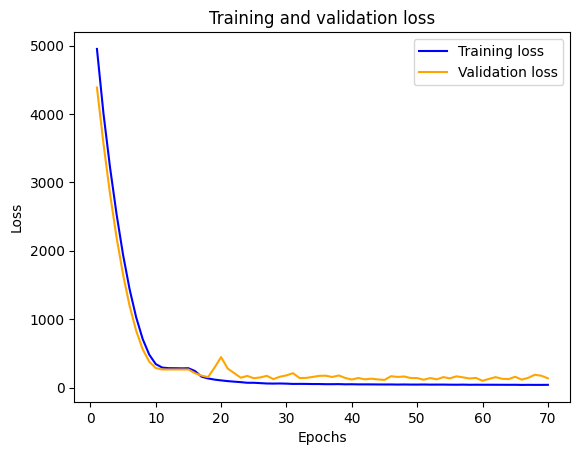

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_sequences, test_labels, verbose=1, batch_size=64)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y_pred = model.predict(test_sequences, verbose=1, batch_size=64)
y_true = y_test

168/168 [==============================] - 1s 4ms/step - loss: 29.9734 - RMSE: 1.8631 - PHME_score: 0.5945 - MAE: 1.8631

RMSE: 1.863085389137268

PHME: 0.5945172905921936

MAE: 1.863085389137268
168/168 [==============================] - 1s 3ms/step


335/335 [==============================] - 1s 3ms/step


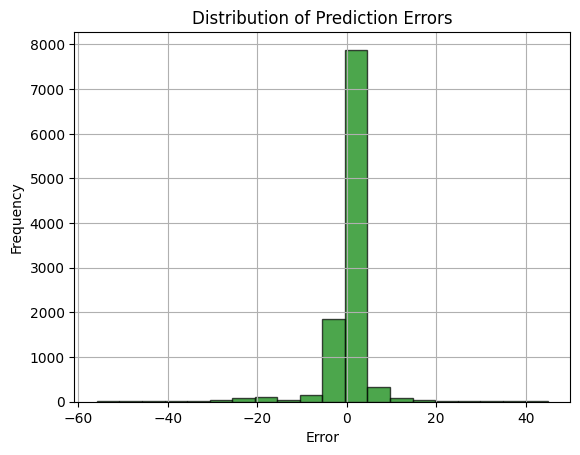

In [ ]:
predictions = model.predict(train_sequences)
errors = predictions.flatten() - test_labels
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
r_squared = r2_score(train_labels, predictions)
print("R-squared:", r_squared)

R-squared: 0.8824042366247395


In [ ]:
print(train_labels)
print(predictions)

[87 87 87 ... 22 21 20]
[[86.86132 ]
 [86.850006]
 [86.8292  ]
 ...
 [24.782024]
 [24.573538]
 [24.398264]]


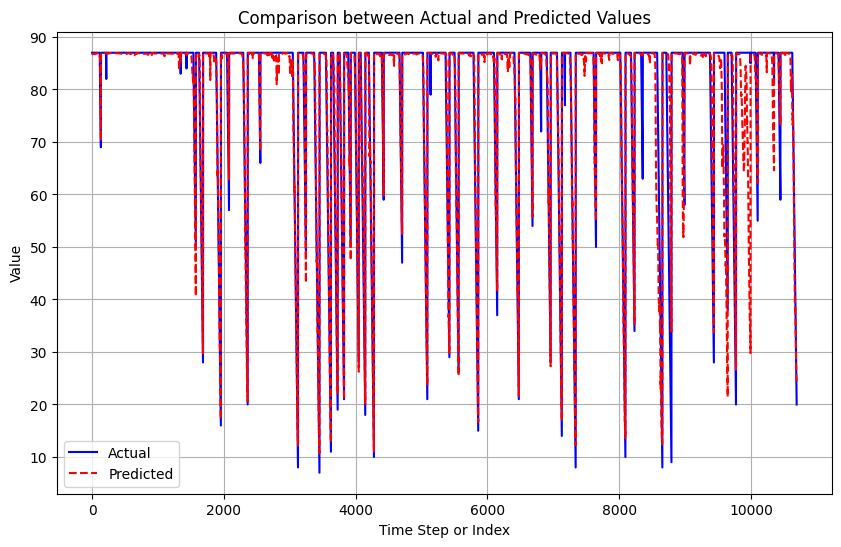

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.plot(train_labels, label='Actual', color='blue', linestyle='-')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

plt.title('Comparison between Actual and Predicted Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
engine_200_data = turbo1_test[turbo1_test['ENr'] == 200]

# Display the selected data
print(engine_200_data)

       ENr    C       T24       T30       T50       P30        Nf        Nc  \
33529  200    1 -1.762682 -0.030502 -0.711917  1.331945 -0.793729 -0.280976   
33530  200    2 -1.857102  0.035151 -0.712127  1.363398 -0.769687 -0.262222   
33531  200    3 -1.778088  0.029666 -0.706037  1.294041 -0.856237 -0.260770   
33532  200    4 -1.686103 -0.014374 -0.779922  1.351822 -0.717758 -0.293558   
33533  200    5 -1.662951 -0.267537 -0.768846  1.283623 -0.773438 -0.281388   
...    ...  ...       ...       ...       ...       ...       ...       ...   
33722  200  194  0.940079  1.111509  1.064589 -0.342708 -0.621418  4.195256   
33723  200  195  1.049468  1.267484  1.098367 -0.337616 -0.668701  4.301137   
33724  200  196  1.141956  1.311131  1.222330 -0.361582 -0.657163  4.385475   
33725  200  197  1.290791  1.285069  1.106267 -0.410197 -0.538591  4.501112   
33726  200  198  1.371073  1.308950  1.189235 -0.404367 -0.504001  4.618409   

           Ps30       phi       NRf       NRc      

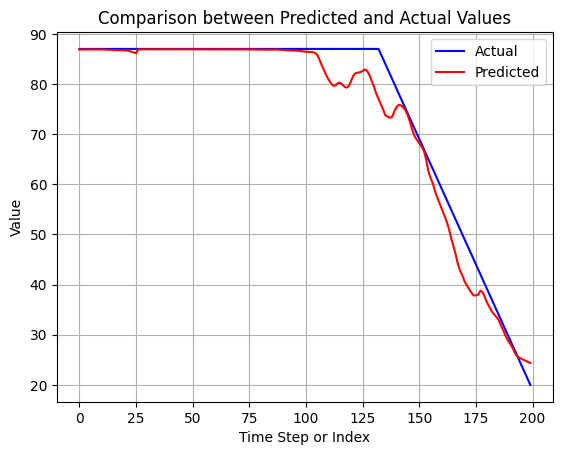

In [ ]:
start_index = 10496
end_index = 10696

# Slice predictions and test_labels arrays to get the interval data
interval_predictions = predictions[start_index:end_index]
interval_test_labels = test_labels[start_index:end_index]

plt.plot(interval_test_labels, label='Actual', color='blue', linestyle='-')
plt.plot(interval_predictions, label='Predicted', color='red', linestyle='-')

plt.title(f'Comparison between Predicted and Actual Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

##FD002

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(sequence_length, train_sequences2.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 25, 64)            3520      
                                                                 
 max_pooling1d_66 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_127 (Dropout)       (None, 25, 64)            0         
                                                                 
 conv1d_67 (Conv1D)          (None, 25, 32)            6176      
                                                                 
 max_pooling1d_67 (MaxPooli  (None, 25, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_66 (LSTM)              (None, 25, 100)         

In [ ]:
history = model.fit(train_sequences2, train_labels2, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
348/348 [==============================] - 7s 10ms/step - loss: 6684.9727 - RMSE: 77.6769 - PHME_score: 8204.3096 - MAE: 77.6769 - val_loss: 5457.8955 - val_RMSE: 70.1280 - val_PHME_score: 2924.3938 - val_MAE: 70.1280
Epoch 2/70
348/348 [==============================] - 3s 8ms/step - loss: 4246.4814 - RMSE: 61.0345 - PHME_score: 1379.2048 - MAE: 61.0345 - val_loss: 3322.0735 - val_RMSE: 54.3133 - val_PHME_score: 505.8353 - val_MAE: 54.3133
Epoch 3/70
348/348 [==============================] - 3s 8ms/step - loss: 2463.4236 - RMSE: 46.2278 - PHME_score: 246.0411 - MAE: 46.2278 - val_loss: 1804.7667 - val_RMSE: 40.0493 - val_PHME_score: 87.3130 - val_MAE: 40.0493
Epoch 4/70
348/348 [==============================] - 3s 8ms/step - loss: 1309.9869 - RMSE: 33.6587 - PHME_score: 44.8829 - MAE: 33.6587 - val_loss: 907.9346 - val_RMSE: 28.1326 - val_PHME_score: 14.8370 - val_MAE: 28.1326
Epoch 5/70
348/348 [==============================] - 3s 7ms/step - loss: 764.9139 - RMSE: 24.02

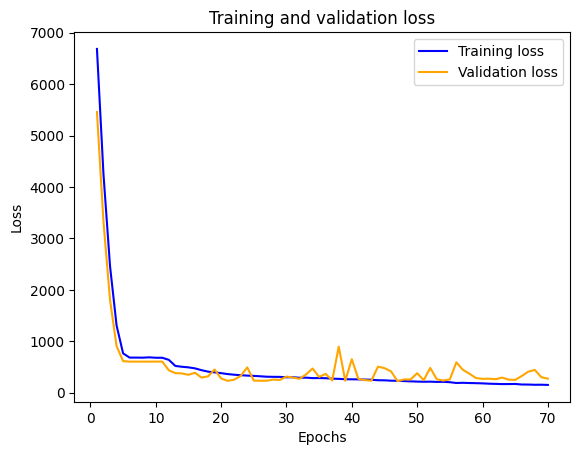

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(train_sequences2, train_labels2, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y2_pred = model.predict(train_sequences2,verbose=1, batch_size=200)
y2_true = y2_test

139/139 [==============================] - 1s 5ms/step - loss: 166.8526 - RMSE: 6.9999 - PHME_score: 0.1838 - MAE: 6.9999

RMSE: 6.999875545501709

PHME: 0.18376658856868744

MAE: 6.999875545501709
139/139 [==============================] - 1s 3ms/step


869/869 [==============================] - 2s 3ms/step


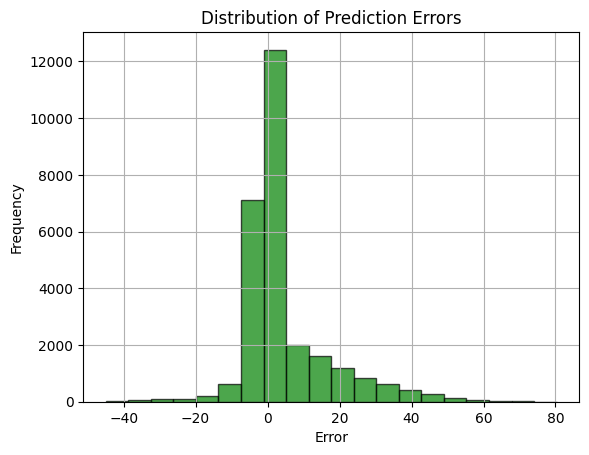

In [ ]:
predictions = model.predict(train_sequences2)
errors = predictions.flatten() - test_labels2
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
r_squared = r2_score(train_labels2, predictions)
print("R-squared:", r_squared)

R-squared: 0.7364238987178944


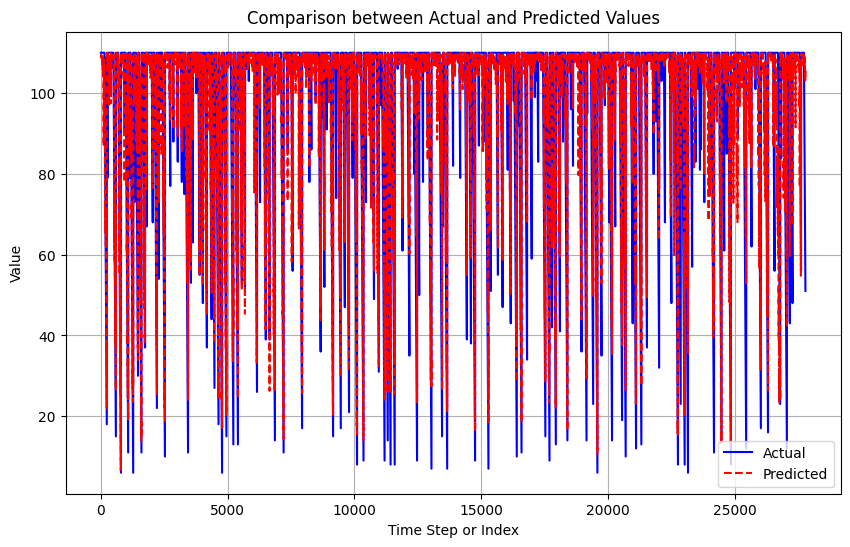

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(train_labels2, label='Actual', color='blue', linestyle='-')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

plt.title('Comparison between Actual and Predicted Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
engine_300_data = turbo2_test[turbo2_test['ENr'] == 300]

# Display the selected data
print(engine_300_data)

       ENr    C      OP-1      OP-2      OP-3        T2       T24       T50  \
58716  300    1  1.220783  0.864687  0.417857 -1.946271 -1.225724 -1.282883   
58717  300    2 -0.269875  0.418479  0.417857 -2.153938 -1.412342 -1.404770   
58718  300    3  1.220397  0.864365  0.417857 -1.676317 -0.989459 -1.105045   
58719  300    4  0.746111  0.864365  0.417857 -1.910980 -1.196866 -1.229578   
58720  300    5 -1.625338 -1.841878  0.417857 -2.058299 -1.314224 -1.351625   
...    ...  ...       ...       ...       ...       ...       ...       ...   
58894  300  179 -1.625203 -1.841878  0.417857 -0.162370  0.292512  0.672840   
58895  300  180 -0.269821  0.413325  0.417857  0.511442  0.904925  1.274798   
58896  300  181 -1.625162 -1.839622  0.417857  0.722525  1.099222  1.354767   
58897  300  182 -0.947854 -1.036448  0.417857  1.307847  1.632078  1.859354   
58898  300  183  0.068992  0.155587 -2.393163  1.408502  1.729139  2.031424   

             P2       epr      Ps30       NRc      

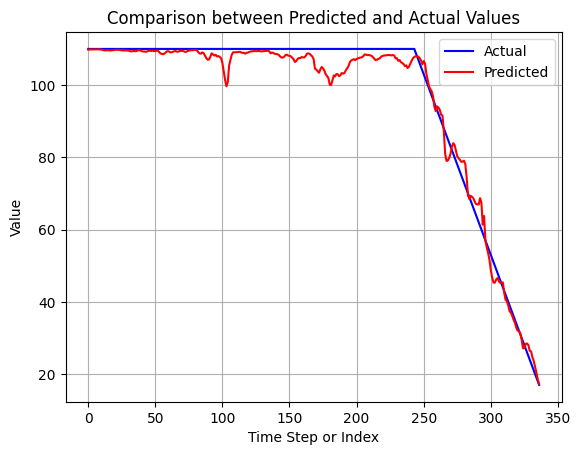

In [ ]:
start_index = 6863
end_index = 7200

# Slice predictions and test_labels arrays to get the interval data
interval_predictions = predictions[start_index:end_index]
interval_test_labels = test_labels2[start_index:end_index]

plt.plot(interval_test_labels, label='Actual', color='blue', linestyle='-')
plt.plot(interval_predictions, label='Predicted', color='red', linestyle='-')

plt.title(f'Comparison between Predicted and Actual Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

##FD003

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(sequence_length, train_sequences3.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 25, 64)            3328      
                                                                 
 max_pooling1d_70 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_133 (Dropout)       (None, 25, 64)            0         
                                                                 
 conv1d_71 (Conv1D)          (None, 25, 32)            6176      
                                                                 
 max_pooling1d_71 (MaxPooli  (None, 25, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_70 (LSTM)              (None, 25, 100)         

In [ ]:
history = model.fit(train_sequences3, train_labels3, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
178/178 [==============================] - 5s 13ms/step - loss: 2716.4036 - RMSE: 51.4798 - PHME_score: 204.6163 - MAE: 51.4798 - val_loss: 2166.1091 - val_RMSE: 45.3999 - val_PHME_score: 112.2161 - val_MAE: 45.3999
Epoch 2/70
178/178 [==============================] - 1s 8ms/step - loss: 1835.9919 - RMSE: 42.2045 - PHME_score: 77.9597 - MAE: 42.2045 - val_loss: 1427.7184 - val_RMSE: 36.6691 - val_PHME_score: 45.1955 - val_MAE: 36.6691
Epoch 3/70
178/178 [==============================] - 1s 8ms/step - loss: 1165.8832 - RMSE: 33.5019 - PHME_score: 31.6821 - MAE: 33.5019 - val_loss: 852.1722 - val_RMSE: 28.2771 - val_PHME_score: 17.9231 - val_MAE: 28.2771
Epoch 4/70
178/178 [==============================] - 1s 8ms/step - loss: 654.7291 - RMSE: 24.9860 - PHME_score: 12.5474 - MAE: 24.9860 - val_loss: 437.7979 - val_RMSE: 20.3506 - val_PHME_score: 6.7915 - val_MAE: 20.3506
Epoch 5/70
178/178 [==============================] - 1s 8ms/step - loss: 311.1716 - RMSE: 16.8930 - PHME

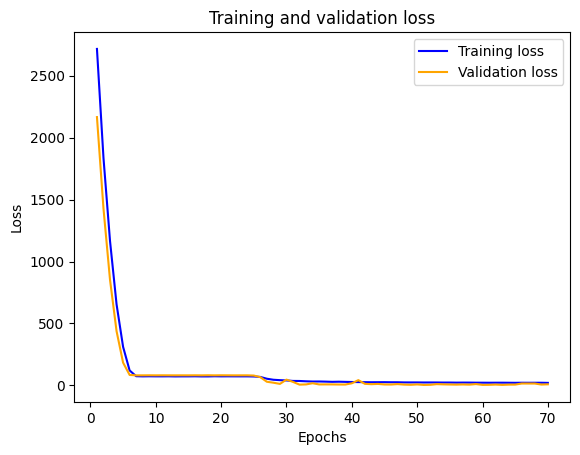

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_sequences3, test_labels3, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y3_pred = model.predict(test_sequences3,verbose=1, batch_size=200)

71/71 [==============================] - 0s 5ms/step - loss: 2.9669 - RMSE: 0.7211 - PHME_score: 0.0256 - MAE: 0.7211

RMSE: 0.7210592031478882

PHME: 0.025584068149328232

MAE: 0.7210592031478882
71/71 [==============================] - 1s 4ms/step


444/444 [==============================] - 1s 3ms/step


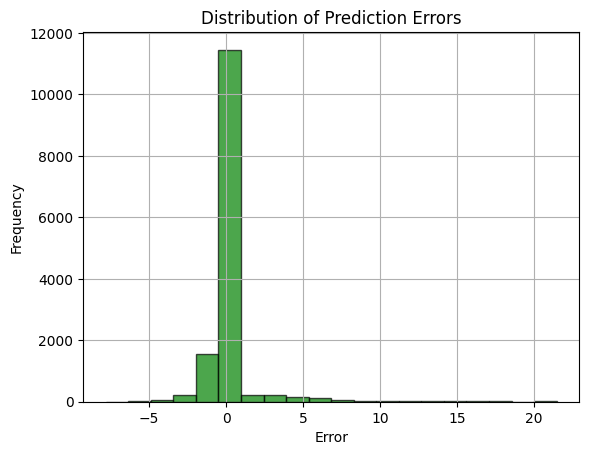

In [ ]:
predictions = model.predict(train_sequences3)
errors = predictions.flatten() - test_labels3
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
r_squared = r2_score(train_labels3, predictions)
print("R-squared:", r_squared)

R-squared: 0.9498213600969504


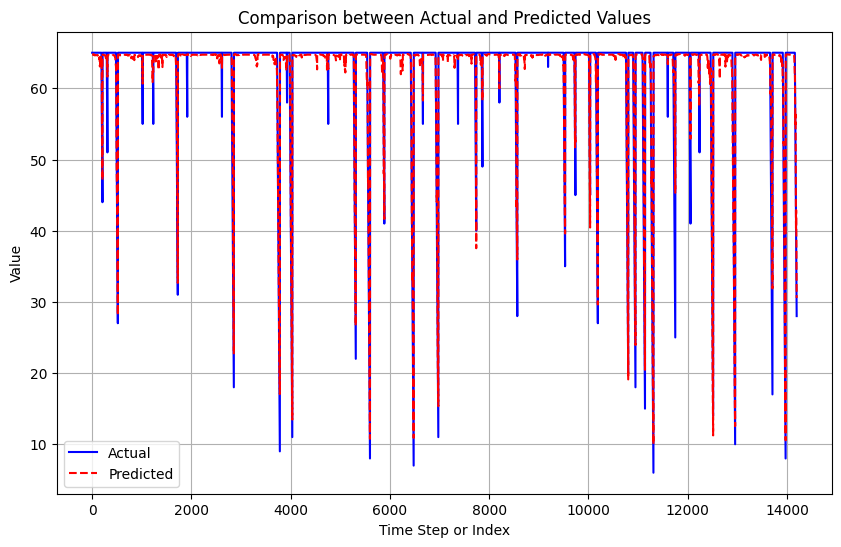

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(train_labels3, label='Actual', color='blue', linestyle='-')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

plt.title('Comparison between Actual and Predicted Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

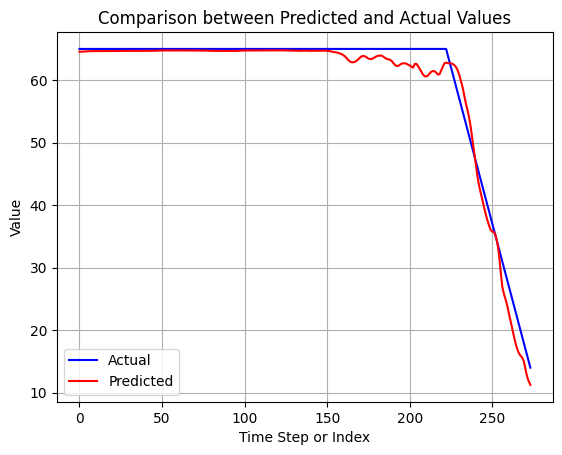

In [ ]:
start_index = 12239
end_index = 12513

interval_predictions = predictions[start_index:end_index]
interval_test_labels = test_labels3[start_index:end_index]

plt.plot(interval_test_labels, label='Actual', color='blue', linestyle='-')
plt.plot(interval_predictions, label='Predicted', color='red', linestyle='-')

plt.title(f'Comparison between Predicted and Actual Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

##FD004

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(sequence_length, train_sequences4.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 25, 64)            3520      
                                                                 
 max_pooling1d_72 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_136 (Dropout)       (None, 25, 64)            0         
                                                                 
 conv1d_73 (Conv1D)          (None, 25, 32)            6176      
                                                                 
 max_pooling1d_73 (MaxPooli  (None, 25, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_72 (LSTM)              (None, 25, 100)         

In [ ]:
history = model.fit(train_sequences4, train_labels4, batch_size=64, epochs=70, validation_split=0.2, verbose=1)

Epoch 1/70
442/442 [==============================] - 8s 10ms/step - loss: 4584.5889 - RMSE: 65.6771 - PHME_score: 1358.5074 - MAE: 65.6771 - val_loss: 3175.8696 - val_RMSE: 54.2983 - val_PHME_score: 341.0880 - val_MAE: 54.2983
Epoch 2/70
442/442 [==============================] - 3s 8ms/step - loss: 2146.0894 - RMSE: 44.4373 - PHME_score: 141.8466 - MAE: 44.4373 - val_loss: 1258.8361 - val_RMSE: 34.3316 - val_PHME_score: 36.0504 - val_MAE: 34.3316
Epoch 3/70
442/442 [==============================] - 3s 8ms/step - loss: 745.2029 - RMSE: 25.5655 - PHME_score: 15.5629 - MAE: 25.5655 - val_loss: 338.9212 - val_RMSE: 17.0492 - val_PHME_score: 3.2000 - val_MAE: 17.0492
Epoch 4/70
442/442 [==============================] - 3s 8ms/step - loss: 294.2027 - RMSE: 12.2583 - PHME_score: 1.5667 - MAE: 12.2583 - val_loss: 234.7080 - val_RMSE: 10.1687 - val_PHME_score: 0.5848 - val_MAE: 10.1687
Epoch 5/70
442/442 [==============================] - 3s 8ms/step - loss: 277.0600 - RMSE: 10.6855 - PHME_

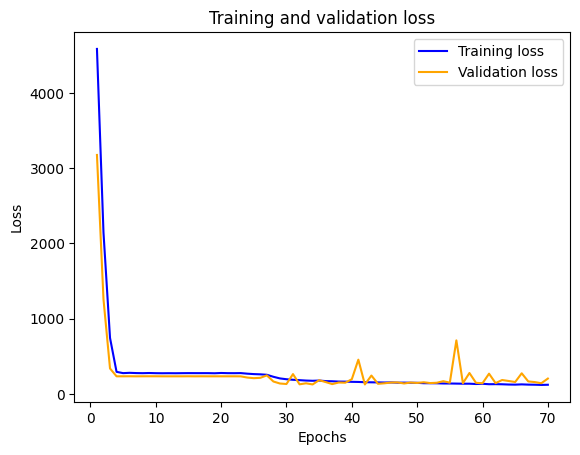

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_sequences4, test_labels4, verbose=1, batch_size=300)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y4_pred = model.predict(test_sequences4,verbose=1, batch_size=300)
y4_true = y4_test

118/118 [==============================] - 1s 5ms/step - loss: 110.1749 - RMSE: 4.7957 - PHME_score: 1.1777 - MAE: 4.7957

RMSE: 4.795655250549316

PHME: 1.1777254343032837

MAE: 4.795655250549316
118/118 [==============================] - 1s 3ms/step


1103/1103 [==============================] - 3s 3ms/step


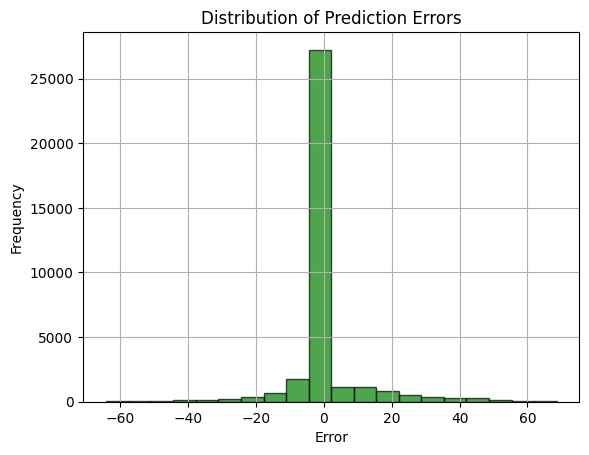

In [ ]:
predictions = model.predict(train_sequences4)
errors = predictions.flatten() - test_labels4
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
r_squared = r2_score(train_labels4, predictions)
print("R-squared:", r_squared)

R-squared: 0.5432232164941302


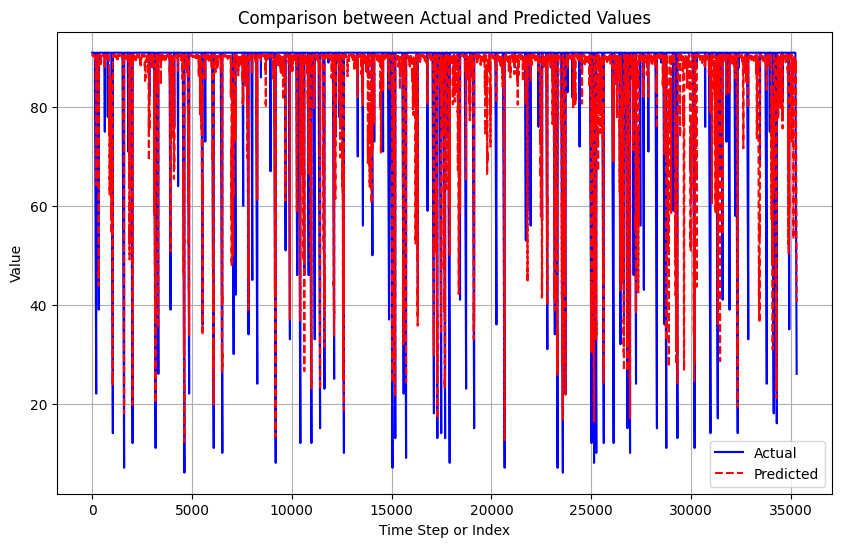

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(train_labels4, label='Actual', color='blue', linestyle='-')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

plt.title('Comparison between Actual and Predicted Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

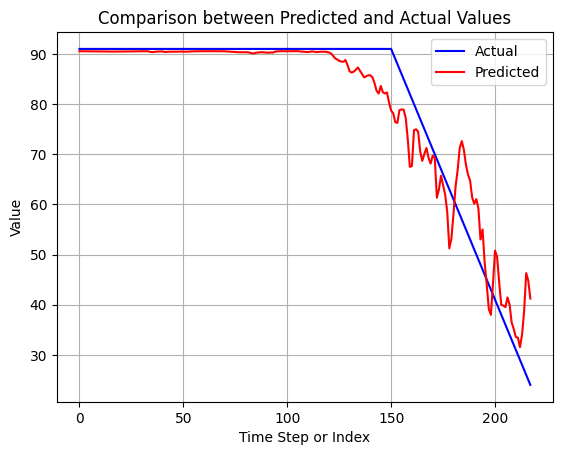

In [ ]:
start_index = 11417
end_index = 11635

interval_predictions = predictions[start_index:end_index]
interval_test_labels = test_labels4[start_index:end_index]

plt.plot(interval_test_labels, label='Actual', color='blue', linestyle='-')
plt.plot(interval_predictions, label='Predicted', color='red', linestyle='-')

plt.title(f'Comparison between Predicted and Actual Values')
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()